# Importación modulos y datos

In [312]:
import numpy as np
import pandas as pd
import matplotlib 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.preprocessing import normalize

import funciones as f

matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [313]:
data = pd.read_csv("../data/conchillas_orig.csv", low_memory = False, keep_default_na = False, na_values = '')
print(data.shape)
data.head(5)

(1688, 12)


Lote  Individuo    AE    LE     AT     LT    AA    LA    NV Morfotipo  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28        LU   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97        LU   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11        LU   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44        LU   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29        LU   

   Labio cox1-lsu  
0      1       AA  
1      1       HG  
2      1      NaN  
3      0      NaN  
4      1      NaN

# Exploración y limpieza de datos

### Agrupación y dummies

In [314]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       1688 non-null   int64  
 1   Individuo  1688 non-null   int64  
 2   AE         1688 non-null   float64
 3   LE         1688 non-null   float64
 4   AT         1688 non-null   float64
 5   LT         1688 non-null   float64
 6   AA         1688 non-null   float64
 7   LA         1688 non-null   float64
 8   NV         1688 non-null   float64
 9   Morfotipo  1688 non-null   object 
 10  Labio      1688 non-null   int64  
 11  cox1-lsu   106 non-null    object 
dtypes: float64(7), int64(3), object(2)
memory usage: 158.4+ KB


In [315]:
# No hay individuos juveniles en el dataset (ancho total menor a 8 milímetros o ausencia de labio)

len(np.logical_or(data.Labio == 1, data.AT >= 8)) == len(data)

True

In [316]:
# Creación de diccionario y reemplazo de haplotipos combinados (105) por haplogrupos (3)
ht = ['AA', 'AB', 'BA', 'CA', 'DA', 'EA', 'FA', 'LA', 'NA', 'OA', 'JH', 'KI', 'GC', 'GD', 'GE', 'GF', 'HG', 'IG', 'MG']
hg = ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '2', '2', '2']
hg_ht_rep = dict(zip(ht, hg))

data["haplogrupos"] = data["cox1-lsu"].replace(hg_ht_rep)

In [317]:
data.iloc[:,2:-3].describe()

AE           LE           AT           LT           AA  \
count  1688.000000  1688.000000  1688.000000  1688.000000  1688.000000   
mean      6.242690     1.763626    13.268957     9.778969     7.692814   
std       0.981426     0.376717     1.942482     1.436368     1.234036   
min       3.120000     0.680000     8.020000     6.050000     4.710000   
25%       5.577500     1.500000    11.777500     8.760000     6.787500   
50%       6.240000     1.760000    13.195000     9.695000     7.590000   
75%       6.892500     2.030000    14.602500    10.845000     8.560000   
max       9.070000     3.150000    19.130000    14.460000    11.970000   

                LA           NV  
count  1688.000000  1688.000000  
mean      6.264846     5.144419  
std       0.914297     0.298324  
min       4.210000     4.000000  
25%       5.600000     4.950000  
50%       6.140000     5.175000  
75%       6.800000     5.340000  
max       9.770000     5.970000

In [318]:
round(data['Morfotipo'].value_counts(normalize = True)*100, 2)
data['haplogrupos'].value_counts()
data['cox1-lsu'].value_counts()

LU    86.02
LB    13.27
DU     0.71
Name: Morfotipo, dtype: float64

0    85
2    12
1     9
Name: haplogrupos, dtype: int64

AA    68
HG    10
LA     3
GC     3
GF     3
BA     3
GE     2
CA     2
OA     2
JH     1
GD     1
KI     1
MG     1
NA     1
AB     1
DA     1
FA     1
IG     1
EA     1
Name: cox1-lsu, dtype: int64

In [319]:
data = pd.get_dummies(data, columns = ["Morfotipo"], drop_first = True)
data.head(5)

Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  Labio  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28      1   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97      1   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11      1   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44      0   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29      1   

  cox1-lsu haplogrupos  Morfotipo_LB  Morfotipo_LU  
0       AA           0             0             1  
1       HG           2             0             1  
2      NaN         NaN             0             1  
3      NaN         NaN             0             1  
4      NaN         NaN             0             1

### Creación columnas nuevas

In [320]:
# Ratios
# Cada parte sobre sí misma
data["Ratio_LE_AE"] = data["LE"]/data["AE"] # Espira
data["Ratio_LT_AT"] = data["LT"]/data["AT"] # Total
data["Ratio_LA_AA"] = data["LA"]/data["AA"] # Abertura

# Espira / Total
data["Ratio_LE_LT"] = data["LE"]/data["LT"] # Largo
data["Ratio_AE_AT"] = data["AE"]/data["AT"] # Ancho

# Abertura / Total
data["Ratio_LA_LT"] = data["LA"]/data["LT"] # Largo
data["Ratio_AA_AT"] = data["AA"]/data["AT"] # Ancho

# Espira / Abertura
data["Ratio_LE_LA"] = data["LE"]/data["LA"] # Largo
data["Ratio_AE_AA"] = data["AE"]/data["AA"] # Ancho

data.head(5)

Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  Labio  ...  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28      1  ...   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97      1  ...   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11      1  ...   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44      0  ...   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29      1  ...   

  Morfotipo_LU Ratio_LE_AE  Ratio_LT_AT  Ratio_LA_AA  Ratio_LE_LT  \
0            1    0.366776     0.747684     0.860321     0.212583   
1            1    0.261101     0.713672     0.918495     0.177108   
2            1    0.288274     0.722585     0.742092     0.177889   
3            1    0.333333     0.785593     0.754573     0.237325   
4            1    0.369028     0.755764     0.849034     0.213537   

   Ratio_AE_AT  Ratio_LA_LT  Ratio_AA_AT  Ratio_LE_LA  Ratio_AE_AA  
0     0.433357     0.663489     0.576622     0.320402     0.751545  
1     0.484093     0.706024     0.548581     0.250853     0.882445  
2     0.445897     0.613065     0.596950     0.290164     0.746959  
3     0.559322     0.533981     0.555932     0.444444     1.006098  
4     0.437320     0.670162     0.596542     0.318634     0.733092  

[5 rows x 23 columns]

In [321]:
# Powers
potencia = 4

# Espira
data["Power_LE"] = data["LE"] ** potencia # Largo
data["Power_AE"] = data["AE"] ** potencia # Ancho

# Total
data["Power_LT"] = data["LT"] ** potencia # Largo
data["Power_AT"] = data["AT"] ** potencia # Ancho

# Abertura
data["Power_LA"] = data["LA"] ** potencia # Largo
data["Power_AA"] = data["AA"] ** potencia # Ancho

# Número de vueltas
data["Power_NV"] = data["NV"] ** potencia

data.head(5)

Lote  Individuo    AE    LE     AT     LT    AA    LA    NV  Labio  ...  \
0    96          1  6.08  2.23  14.03  10.49  8.09  6.96  5.28      1  ...   
1    96          2  5.63  1.47  11.63   8.30  6.38  5.86  4.97      1  ...   
2    96          5  6.14  1.77  13.77   9.95  8.22  6.10  5.11      1  ...   
3    96          6  6.60  2.20  11.80   9.27  6.56  4.95  5.44      0  ...   
4    96          7  6.07  2.24  13.88  10.49  8.28  7.03  5.29      1  ...   

  Ratio_AA_AT Ratio_LE_LA  Ratio_AE_AA   Power_LE     Power_AE      Power_LT  \
0    0.576622    0.320402     0.751545  24.729734  1366.514729  12108.823608   
1    0.548581    0.250853     0.882445   4.669489  1004.693470   4745.832100   
2    0.596950    0.290164     0.746959   9.815062  1421.259840   9801.495006   
3    0.555932    0.444444     1.006098  23.425600  1897.473600   7384.463302   
4    0.596542    0.318634     0.733092  25.176310  1357.546656  12108.823608   

       Power_AT     Power_LA     Power_AA    Power_NV  
0  38746.339913  2346.588611  4283.453794  777.205187  
1  18294.428998  1179.208128  1656.848179  610.134461  
2  35953.051846  1384.584100  4565.488679  681.841766  
3  19387.777600   600.372506  1851.890729  875.781161  
4  37115.717839  2442.425357  4700.254211  783.109853  

[5 rows x 30 columns]

In [322]:
# Power_ratios
# (Cada parte sobre sí misma) ** potencia
data["Power_Ratio_LE_AE"] = data["Ratio_LE_AE"] ** potencia # Espira
data["Power_Ratio_LT_AT"] = data["Ratio_LT_AT"] ** potencia # Total
data["Power_Ratio_LA_AA"] = data["Ratio_LA_AA"] ** potencia # Abertura

# (Espira / Total) ** potencia
data["Power_Ratio_LE_LT"] = data["Ratio_LE_LT"] ** potencia # Largo
data["Power_Ratio_AE_AT"] = data["Ratio_AE_AT"] ** potencia # Ancho

# (Abertura / Total) ** potencia
data["Power_Ratio_LA_LT"] = data["Ratio_LA_LT"] ** potencia # Largo
data["Power_Ratio_AA_AT"] = data["Ratio_AA_AT"] ** potencia # Ancho

# (Espira / Abertura) ** potencia
data["Power_Ratio_LE_LA"] = data["Ratio_LE_LA"] ** potencia # Largo
data["Power_Ratio_AE_AA"] = data["Ratio_AE_AA"] ** potencia # Ancho

In [323]:
data.columns

Index(['Lote', 'Individuo', 'AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Labio',
       'cox1-lsu', 'haplogrupos', 'Morfotipo_LB', 'Morfotipo_LU',
       'Ratio_LE_AE', 'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT',
       'Ratio_AE_AT', 'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA',
       'Ratio_AE_AA', 'Power_LE', 'Power_AE', 'Power_LT', 'Power_AT',
       'Power_LA', 'Power_AA', 'Power_NV', 'Power_Ratio_LE_AE',
       'Power_Ratio_LT_AT', 'Power_Ratio_LA_AA', 'Power_Ratio_LE_LT',
       'Power_Ratio_AE_AT', 'Power_Ratio_LA_LT', 'Power_Ratio_AA_AT',
       'Power_Ratio_LE_LA', 'Power_Ratio_AE_AA'],
      dtype='object')

### Relación entre variables

In [324]:
Medidas = ['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Morfotipo_LB', 'Morfotipo_LU']
Ratios = ['Ratio_LE_AE', 'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT', 'Ratio_AE_AT', 'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA', 'Ratio_AE_AA', 'Morfotipo_LB', 'Morfotipo_LU']
Powers = ['Power_LE', 'Power_AE', 'Power_LT', 'Power_AT', 'Power_LA', 'Power_AA', 'Power_NV', 'Morfotipo_LB', 'Morfotipo_LU']
Powers_ratios = ['Power_Ratio_LE_AE', 'Power_Ratio_LT_AT', 'Power_Ratio_LA_AA', 'Power_Ratio_LE_LT', 'Power_Ratio_AE_AT', 'Power_Ratio_LA_LT', 'Power_Ratio_AA_AT', 'Power_Ratio_LE_LA', 'Power_Ratio_AE_AA', 'Morfotipo_LB', 'Morfotipo_LU']
Todo = Medidas + Ratios + Powers + Powers_ratios
Todo = list(dict.fromkeys(Todo)) #para eliminar elementos duplicados de una lista
print(Todo)

['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'Morfotipo_LB', 'Morfotipo_LU', 'Ratio_LE_AE', 'Ratio_LT_AT', 'Ratio_LA_AA', 'Ratio_LE_LT', 'Ratio_AE_AT', 'Ratio_LA_LT', 'Ratio_AA_AT', 'Ratio_LE_LA', 'Ratio_AE_AA', 'Power_LE', 'Power_AE', 'Power_LT', 'Power_AT', 'Power_LA', 'Power_AA', 'Power_NV', 'Power_Ratio_LE_AE', 'Power_Ratio_LT_AT', 'Power_Ratio_LA_AA', 'Power_Ratio_LE_LT', 'Power_Ratio_AE_AT', 'Power_Ratio_LA_LT', 'Power_Ratio_AA_AT', 'Power_Ratio_LE_LA', 'Power_Ratio_AE_AA']


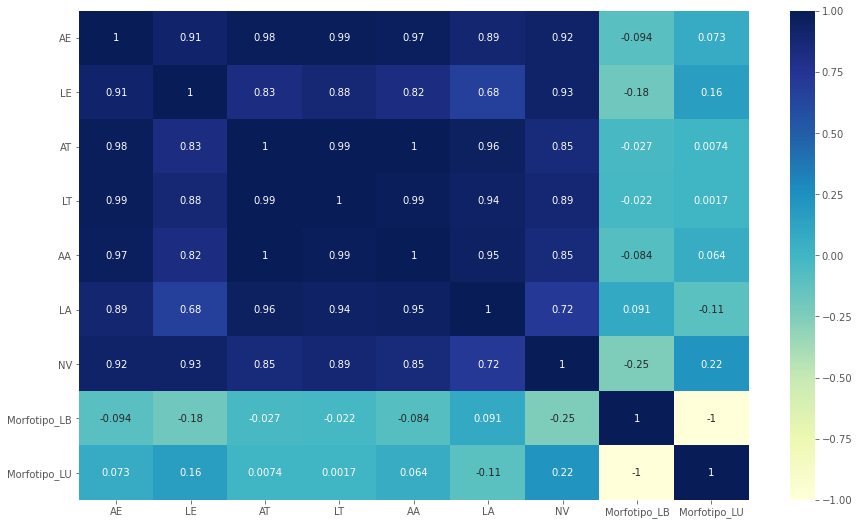

In [325]:
#variables originales del dataset
f._print_matriz_correlacion(data[Medidas].corr())

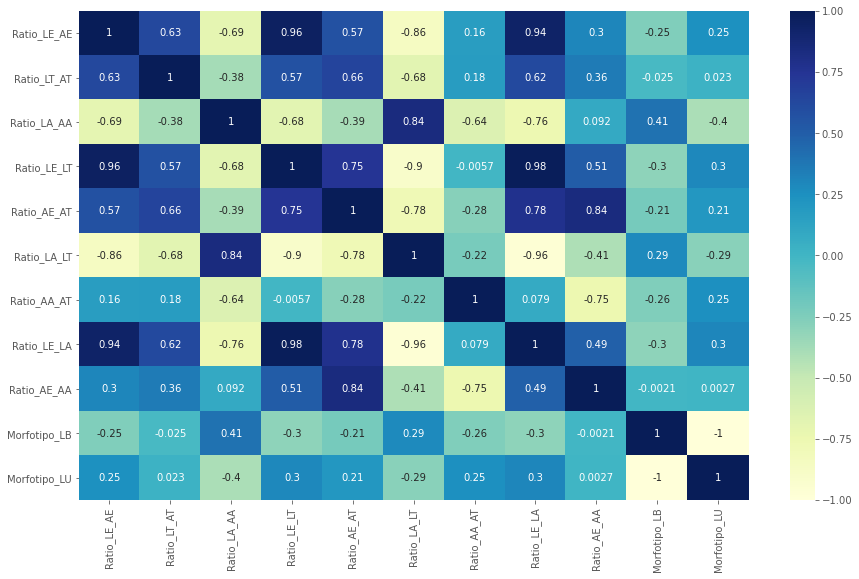

In [326]:
#variables originales del dataset
f._print_matriz_correlacion(data[Ratios].corr())

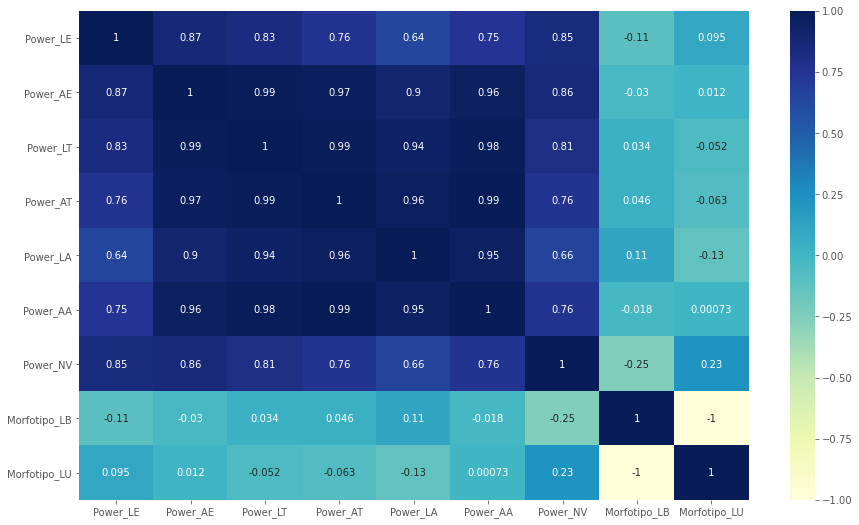

In [327]:
#variables originales del dataset
f._print_matriz_correlacion(data[Powers].corr())

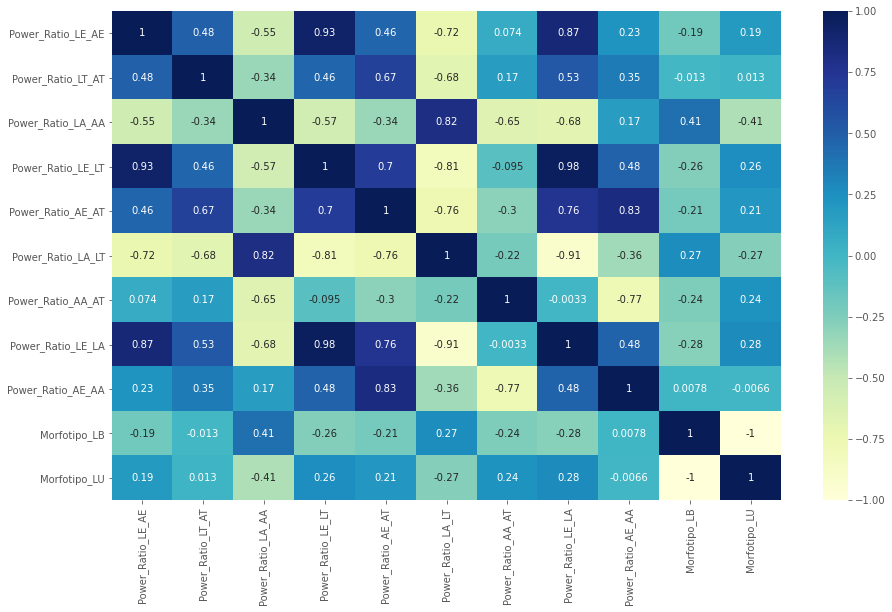

In [328]:
#variables originales del dataset
f._print_matriz_correlacion(data[Powers_ratios].corr())

In [329]:
# sns.pairplot(data=data,x_vars = Medidas,\
#          y_vars= Medidas,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [330]:
# sns.pairplot(data=data,x_vars = Ratios,\
#          y_vars= Ratios,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [331]:
# sns.pairplot(data=data,x_vars = Powers,\
#          y_vars= Powers,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [332]:
# sns.pairplot(data=data,x_vars = Powers_ratios,\
#          y_vars= Powers_ratios,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

In [333]:
#sns.pairplot(data=data,x_vars = Todo,\
#         y_vars= Todo,hue='haplogrupos',plot_kws={'alpha': 0.5},aspect=1.5);

### Distribución de las observaciones

In [334]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 9))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

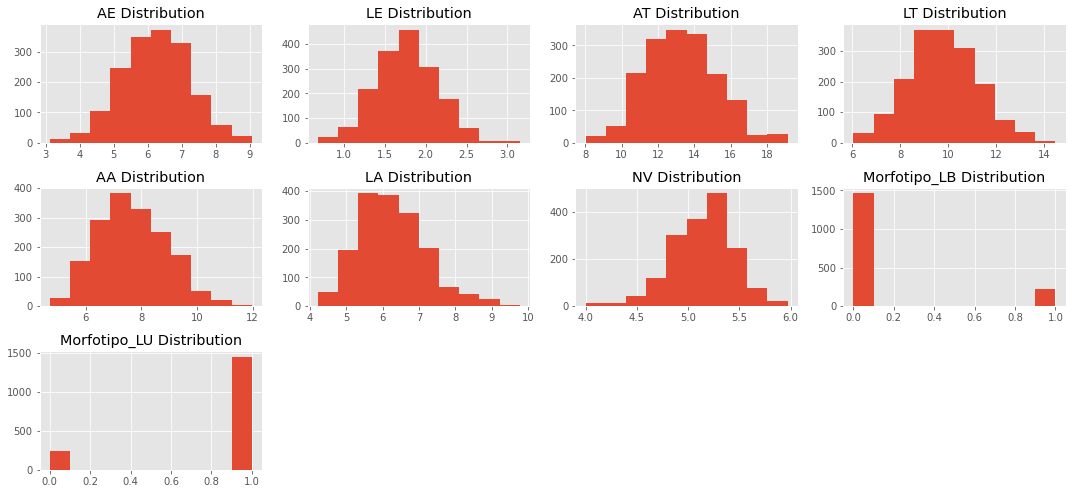

In [335]:
draw_histograms(data, data[Medidas], 4, 4)

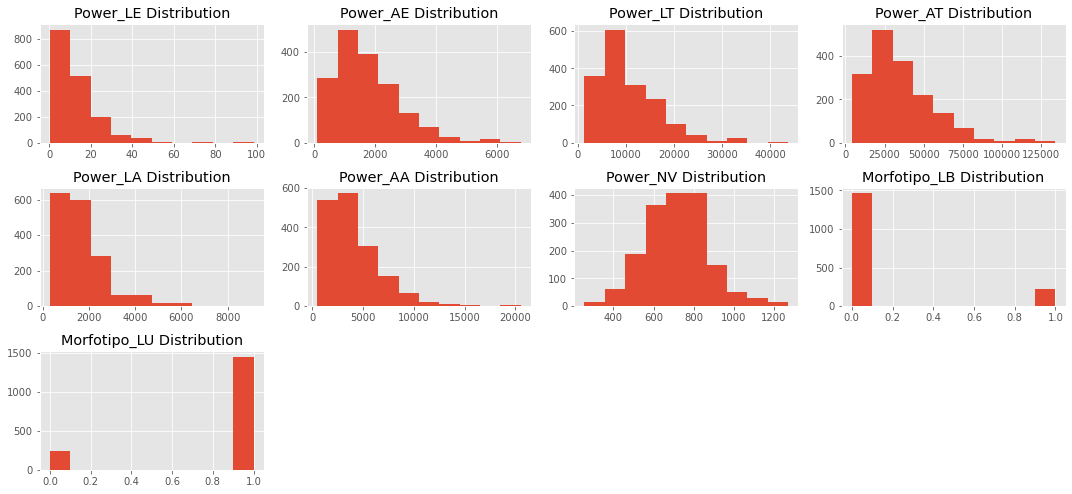

In [336]:
draw_histograms(data, data[Powers], 4, 4)

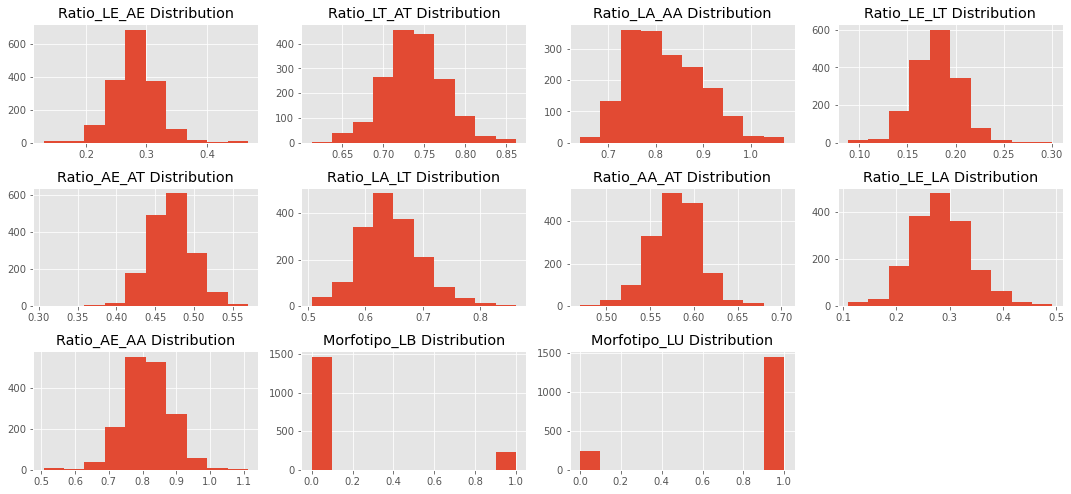

In [337]:
draw_histograms(data, data[Ratios], 4, 4)

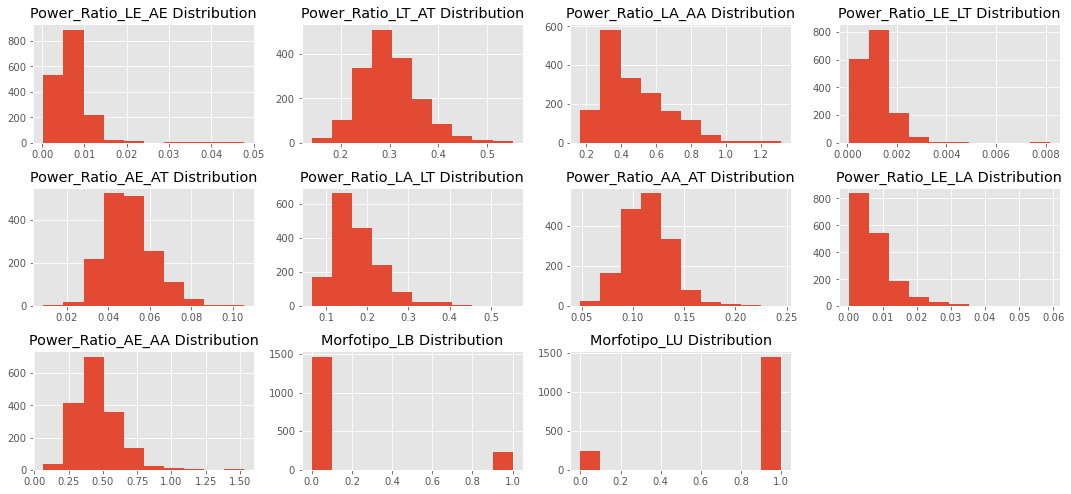

In [338]:
draw_histograms(data, data[Powers_ratios], 4, 4)

# Modelos de clustering

In [339]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.cm as cm

## KMEANS

### Variables

In [340]:
x1 = data[Medidas]
x2 = data[Powers]
x3 = data[Ratios]
x4 = data[Powers_ratios]
x5 = data[Todo]
y_true = data["haplogrupos"]

scaler = StandardScaler()
x1_scaled=scaler.fit_transform(x1)
x2_scaled=scaler.fit_transform(x2)
x3_scaled=scaler.fit_transform(x3)
x4_scaled=scaler.fit_transform(x4)
x5_scaled=scaler.fit_transform(x5)


### Numero de clusters por SQ distance

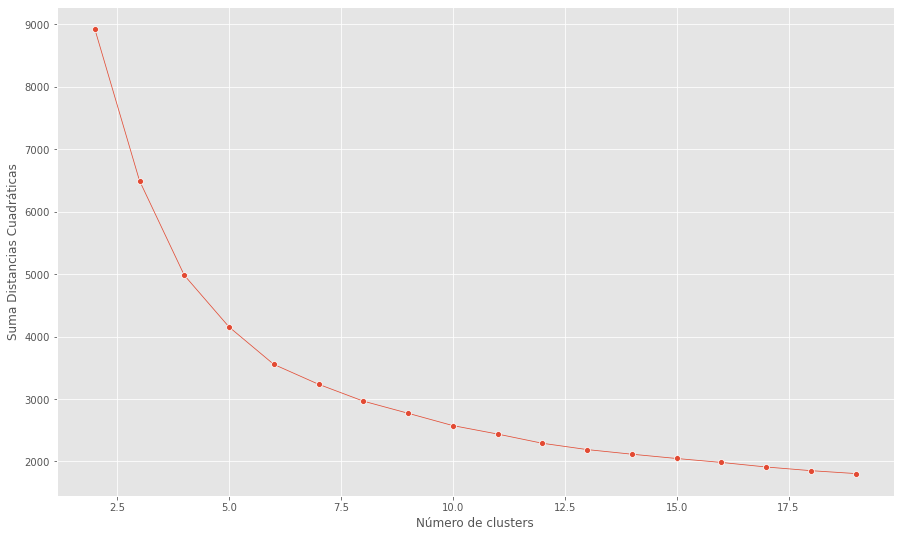

In [341]:
#x1_scaled medidas
sq_distances=[]
k_values=range(2,20);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x1_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

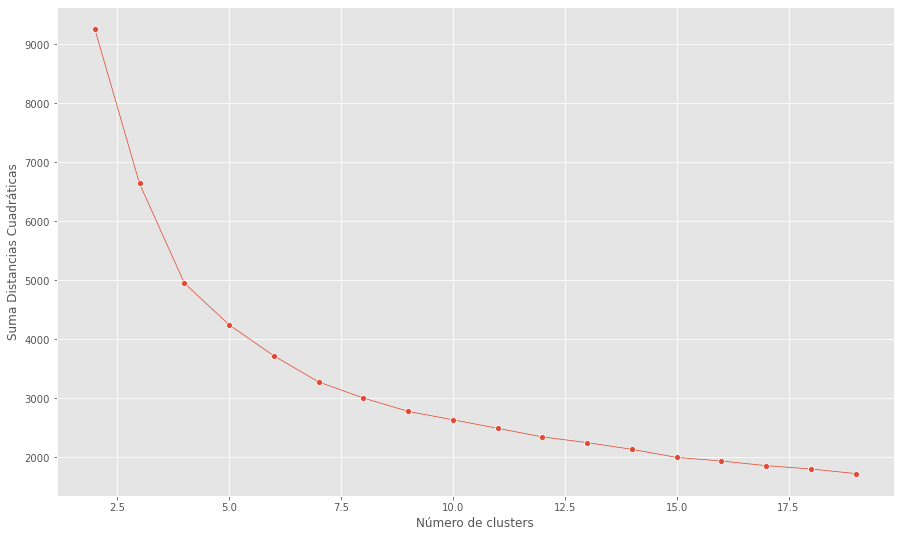

In [342]:
#x2_scaled powers
sq_distances=[]
k_values=range(2,20);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x2_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

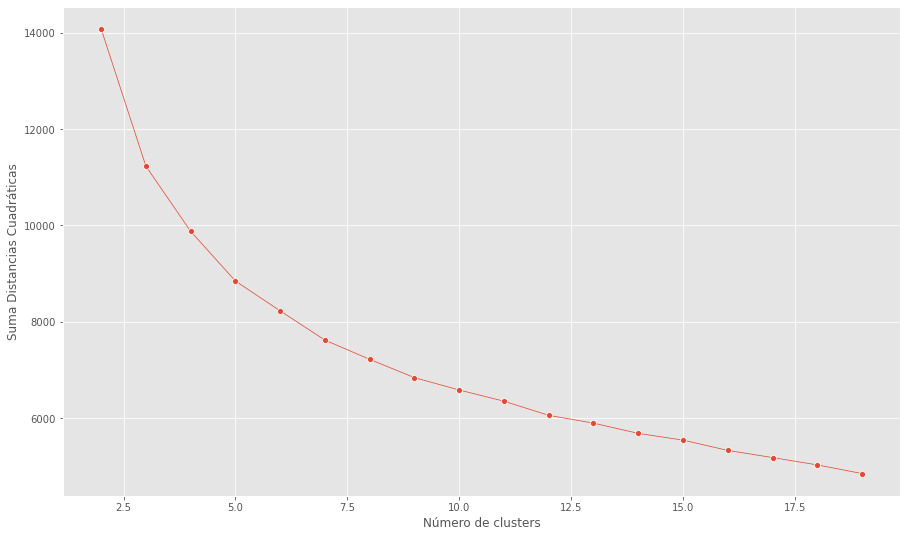

In [343]:
#x3_scaled ratios
sq_distances=[]
k_values=range(2,20);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x3_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

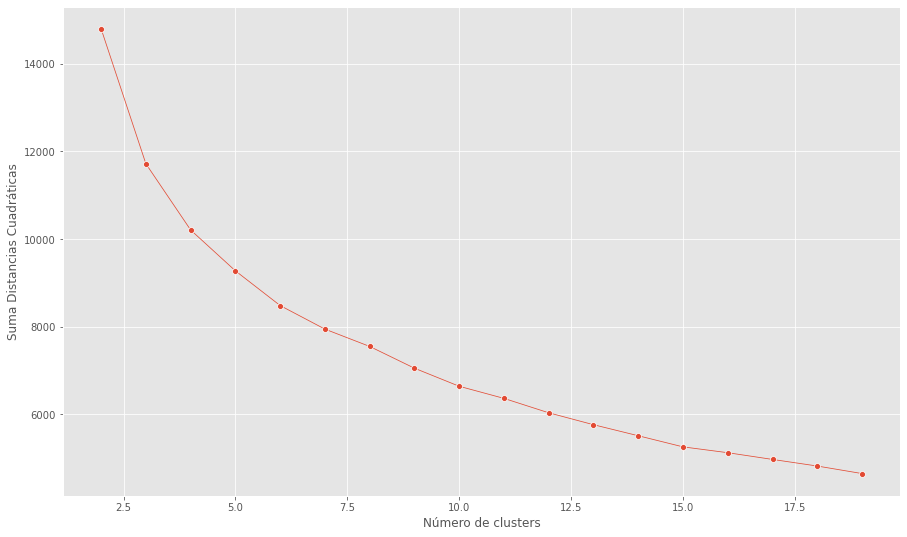

In [344]:
#x4_scaled powers ratios
sq_distances=[]
k_values=range(2,20);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x4_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

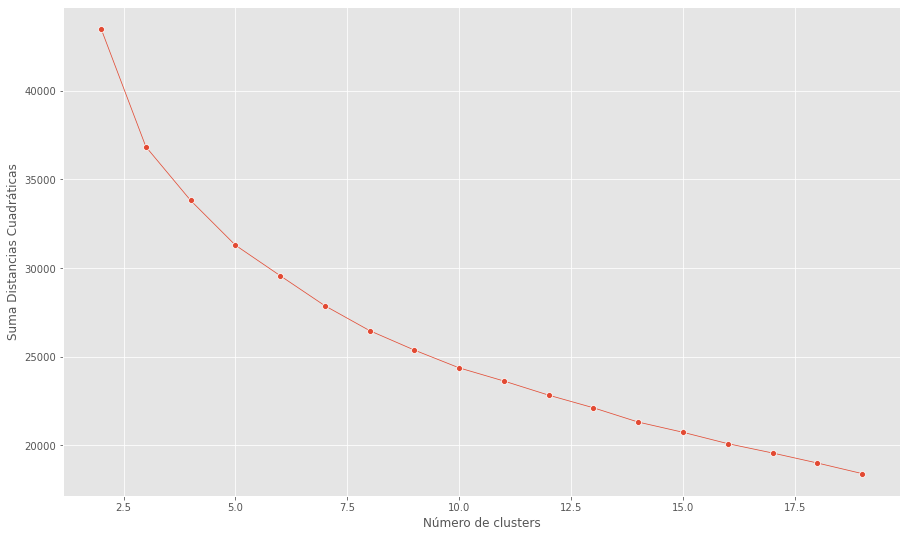

In [345]:
#x5_scaled todo
sq_distances=[]
k_values=range(2,20);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x5_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

### Numero de clusters por silohuette score

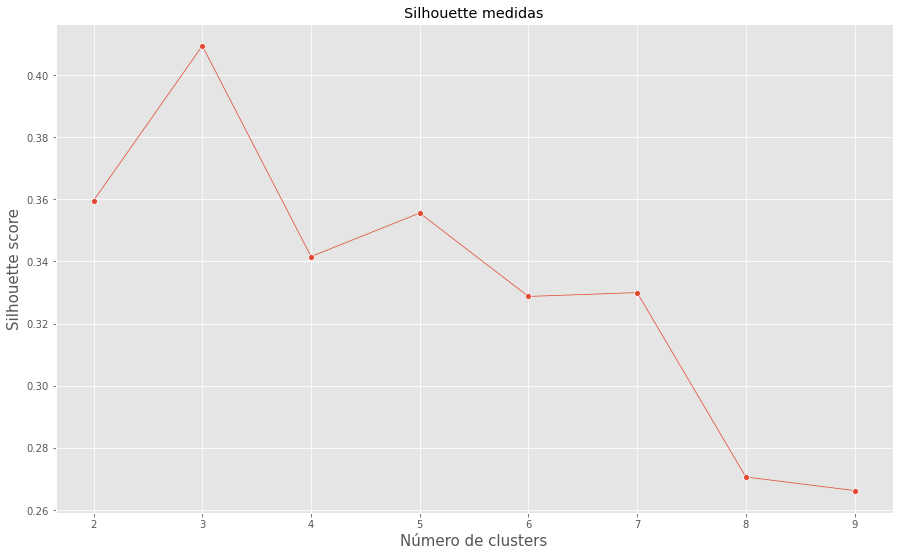

In [346]:
#x1_scaled medidas
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x1_scaled)
    score=silhouette_score(x1_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15); plt.title('Silhouette medidas');

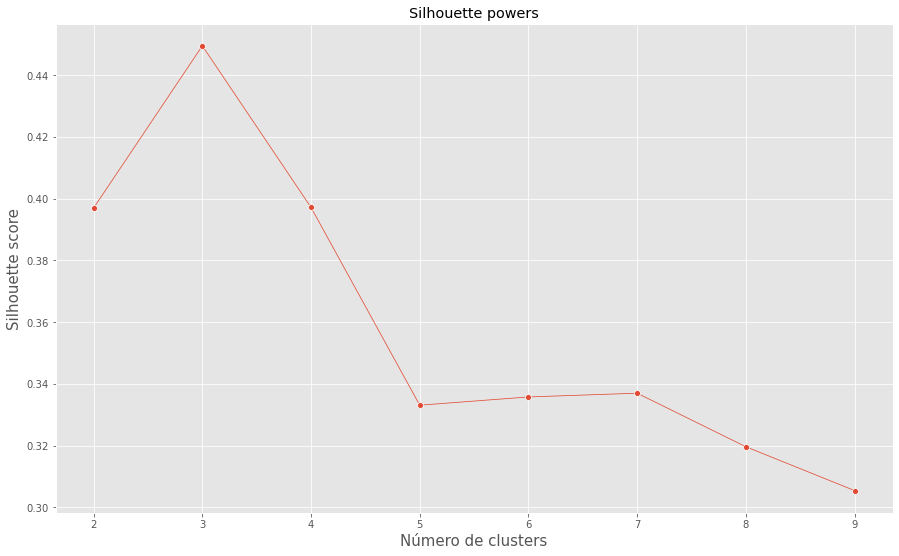

In [347]:
#x2_scaled powers
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x2_scaled)
    score=silhouette_score(x2_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);  plt.title('Silhouette powers');

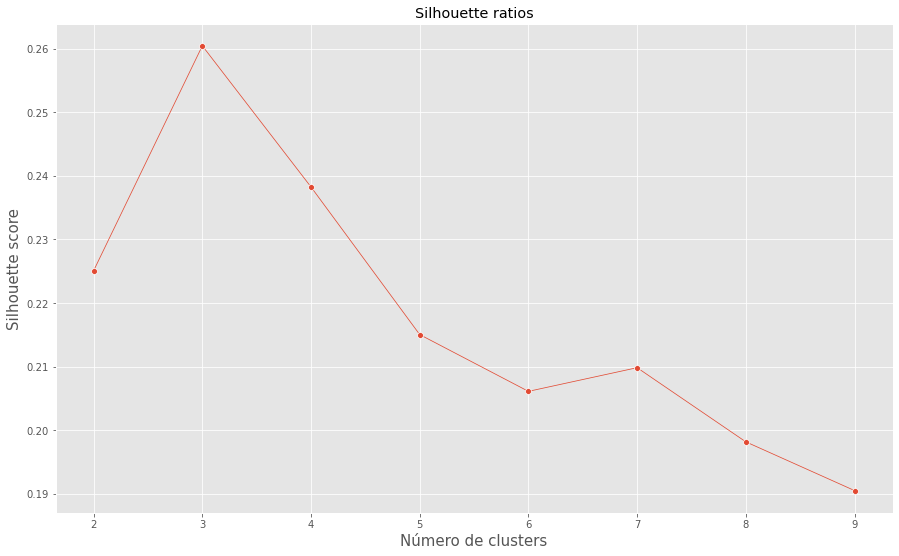

In [348]:
#x3_scaled ratios
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x3_scaled)
    score=silhouette_score(x3_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15); plt.title('Silhouette ratios');

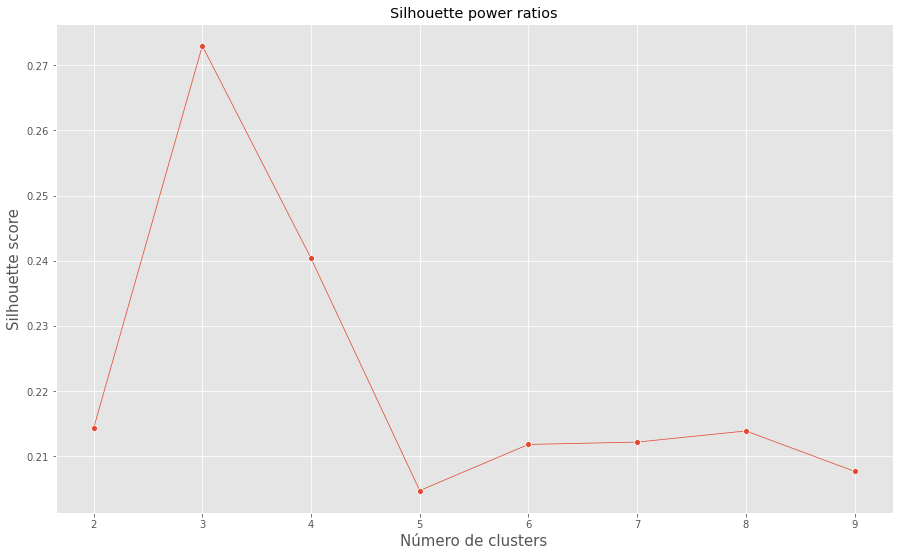

In [349]:
#x4_scaled power ratios
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x4_scaled)
    score=silhouette_score(x4_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15); plt.title('Silhouette power ratios');

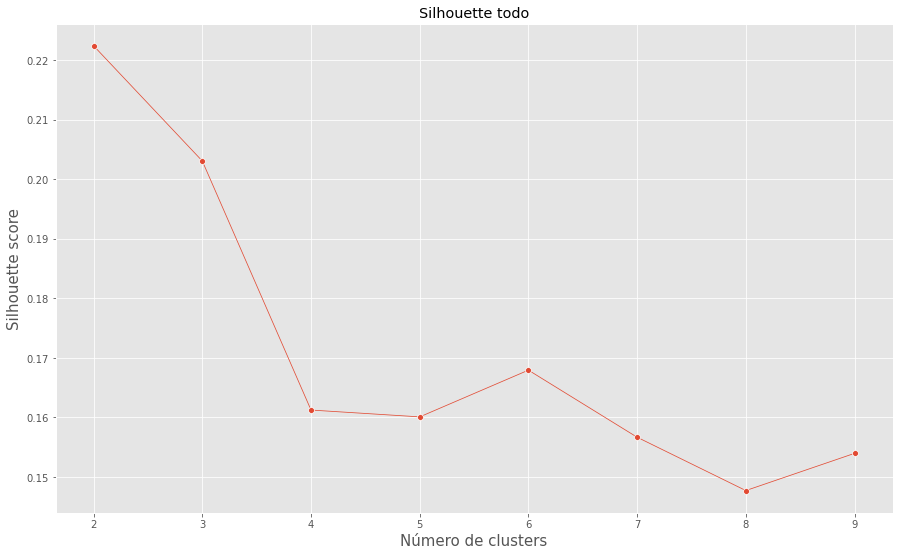

In [350]:
#x5_scaled todo
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x5_scaled)
    score=silhouette_score(x5_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15); plt.title('Silhouette todo');

### Kmeans 

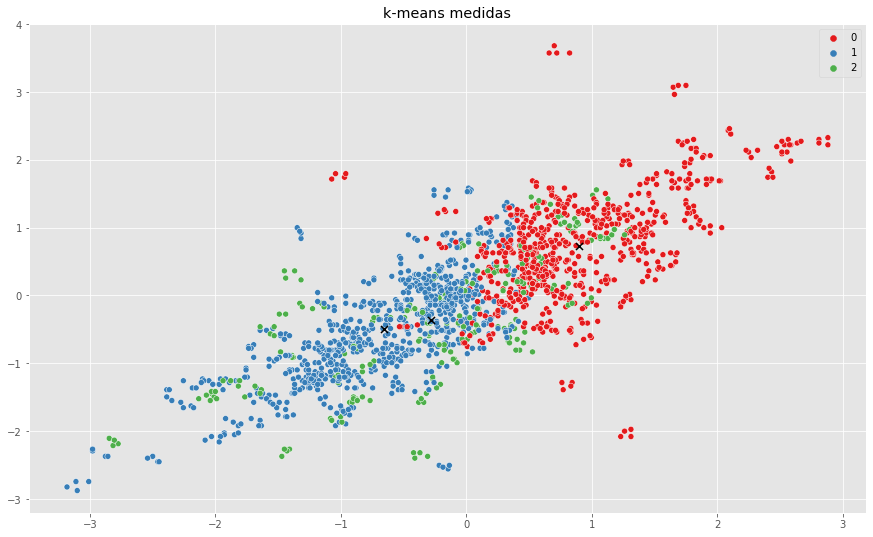

In [351]:
#x1_scaled medidas
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x1_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x1_scaled[:,0],y=x1_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k'); plt.title('k-means medidas');

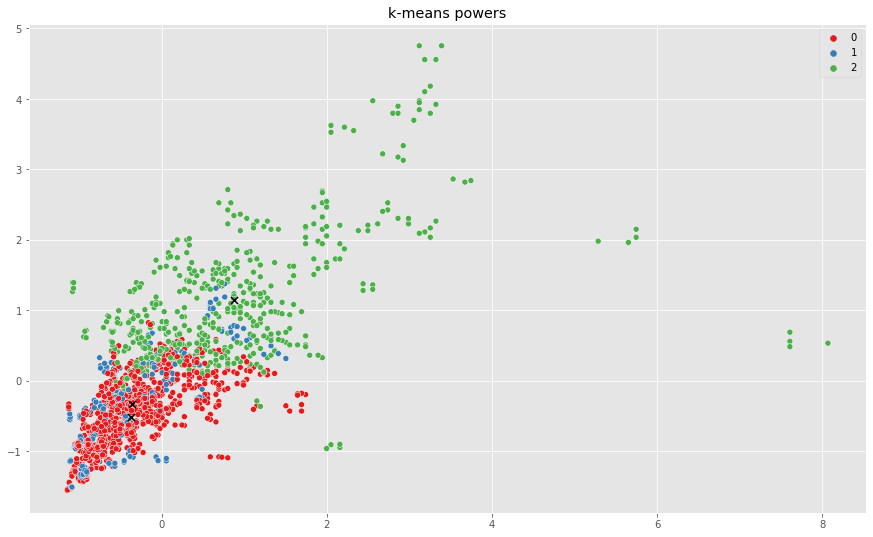

In [352]:
#x2_scaled powers
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x2_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x2_scaled[:,0],y=x2_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k'); plt.title('k-means powers');

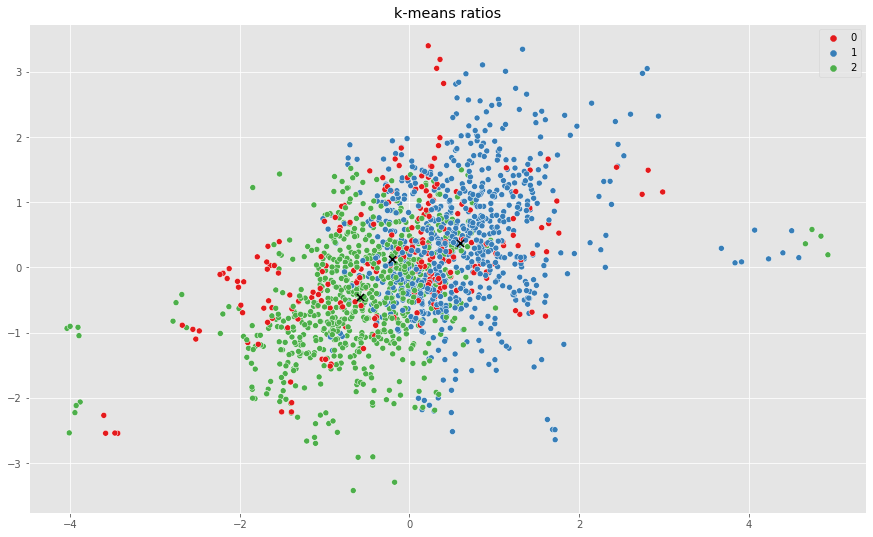

In [353]:
#x3_scaled ratios
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x3_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x3_scaled[:,0],y=x3_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k'); plt.title('k-means ratios');

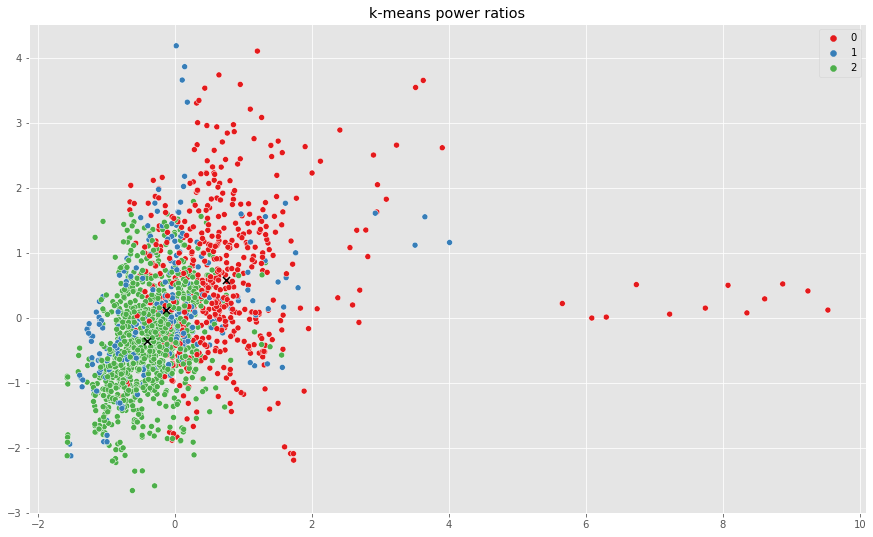

In [354]:
#x4_scaled powers ratios
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x4_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x4_scaled[:,0],y=x4_scaled[:,1],hue=labels,legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k'); plt.title('k-means power ratios');

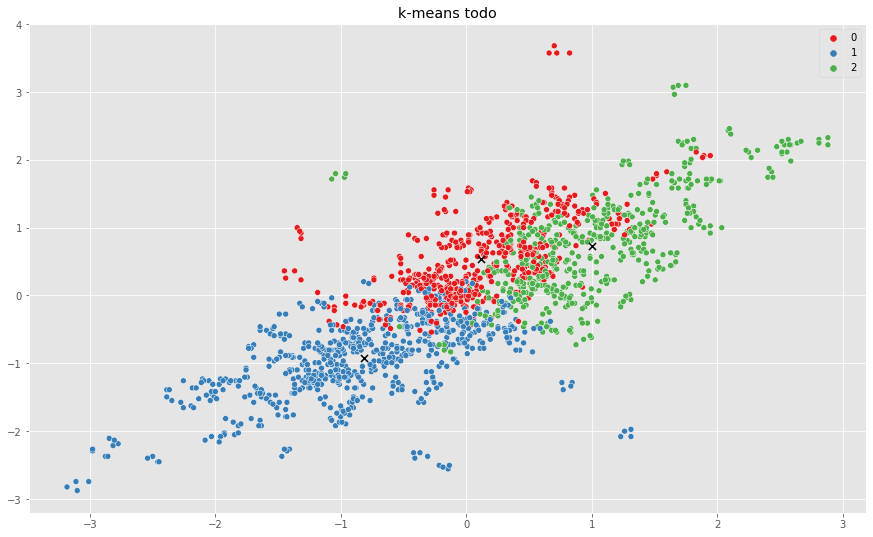

In [355]:
#x5_scaled todo
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x5_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x5_scaled[:,0],y=x5_scaled[:,1],hue=labels,legend='full', palette="Set1");

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k'); plt.title('k-means todo');

### Comparación True labels vs Kmeans

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

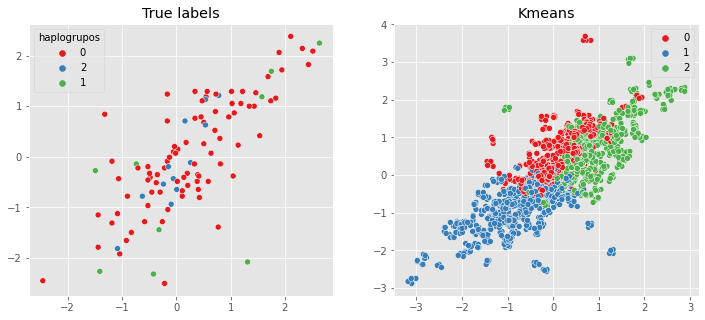

In [356]:
#x1_scaled medidas
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

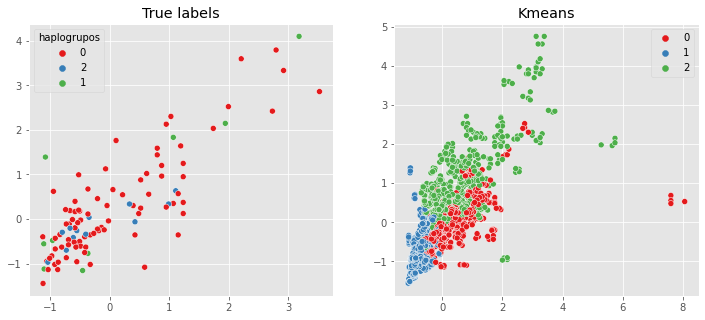

In [357]:
#x2_scaled powers
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

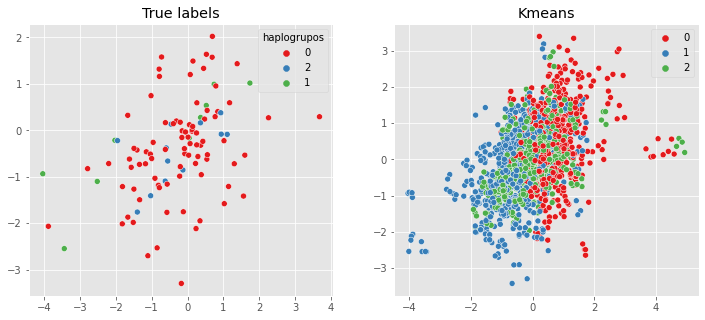

In [358]:
#x3_scaled ratios
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

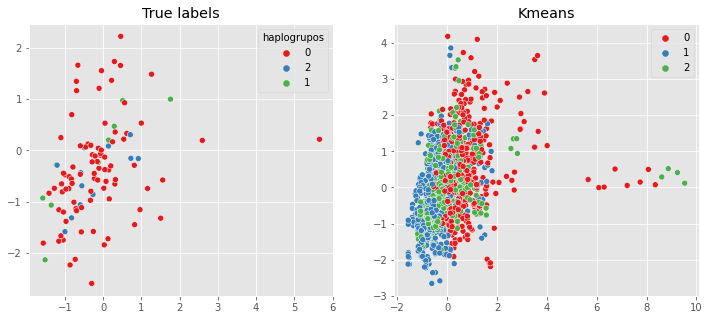

In [359]:
#x4_scaled powers ratios
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

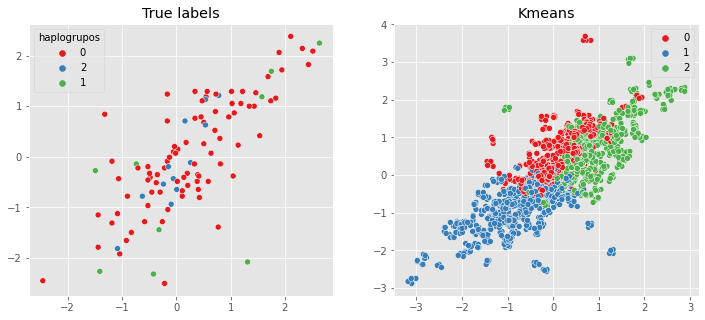

In [360]:
#x5_scaled todos
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')



<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

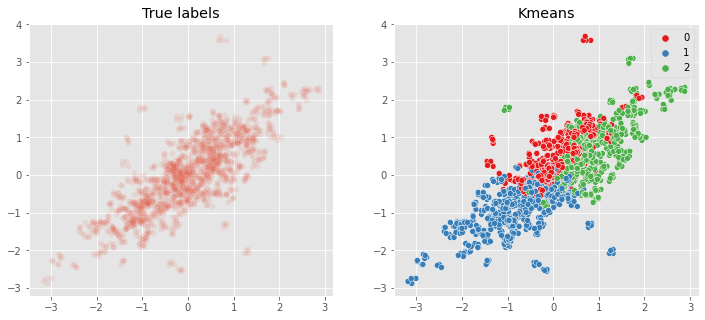

In [361]:
#x5_scaled todos (agregamos alpha)
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],ax=ax[0], alpha=0.1)
#sns.scatterplot(x = x_scaled[indices,0], y = x_scaled[indices,1],hue=y_true[y_true!="0"],ax=ax[0], palette="magma")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels,ax=ax[1], palette = 'Set1')
ax[1].set_title('Kmeans')

In [362]:
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

## DBSCAN

In [363]:
from scipy.spatial.distance import pdist,squareform

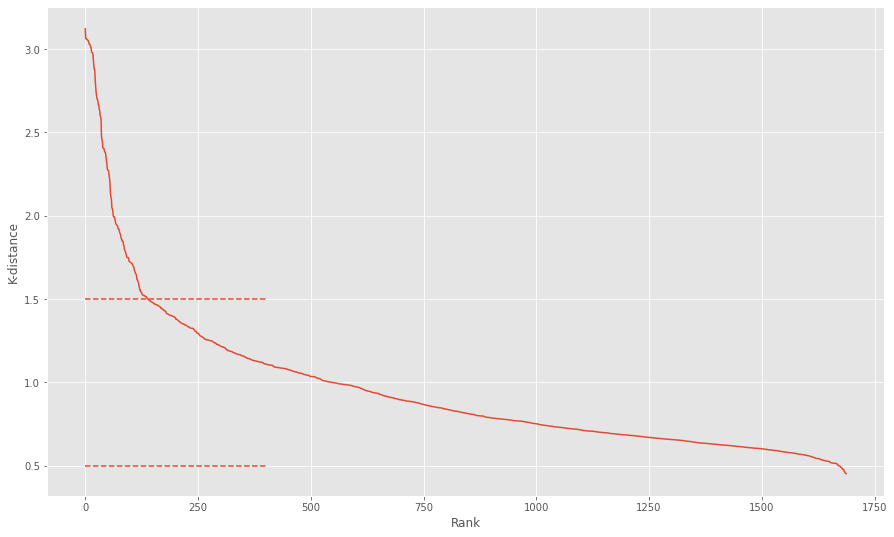

In [364]:
#x1_scaled medidas
minPts=20;
k=minPts-1;

D=squareform(pdist(x1_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([0.5,1.5],0,400,linestyles='dashed');

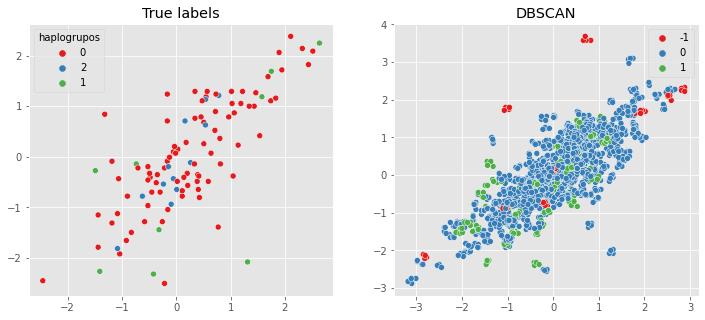

In [365]:
#x1_scaled medidas
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x1_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x1_scaled[:,0], y = x1_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');


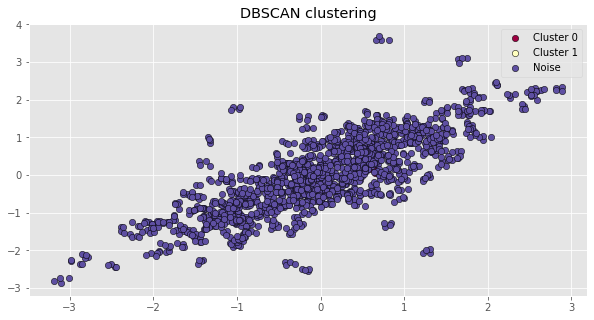

In [366]:
#x1_scaled medidas
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x1_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x1_scaled[labels==l,0], x1_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x1_scaled[labels==l,0], x1_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

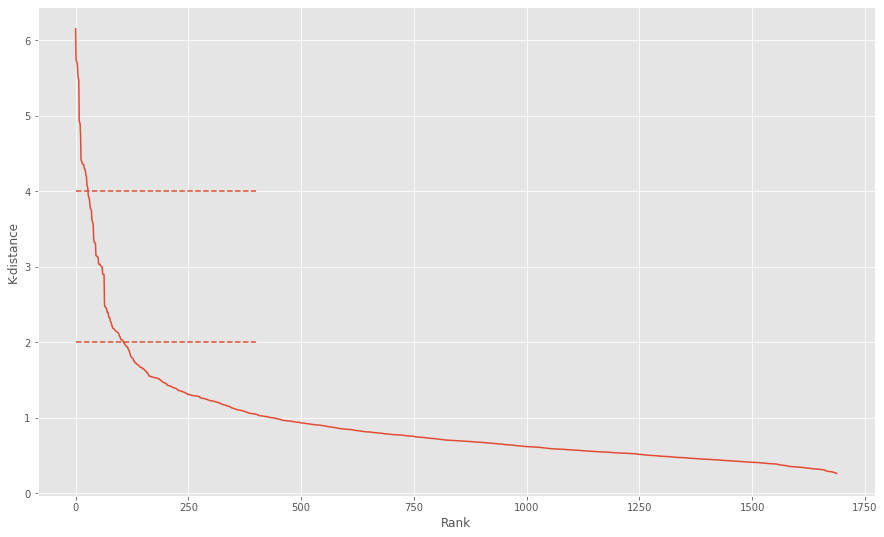

In [367]:
#x2_scaled powers
minPts=20;
k=minPts-1;

D=squareform(pdist(x2_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

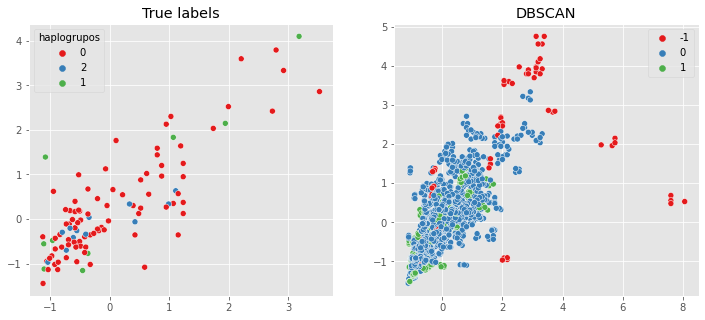

In [368]:
#x2_scaled powers
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x2_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x2_scaled[:,0], y = x2_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');

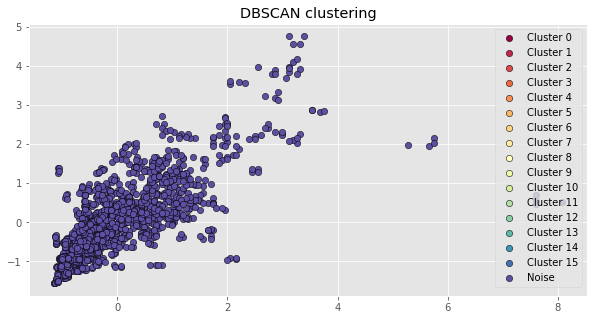

In [369]:
#x2_scaled medidas
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x2_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x2_scaled[labels==l,0], x2_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x2_scaled[labels==l,0], x2_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

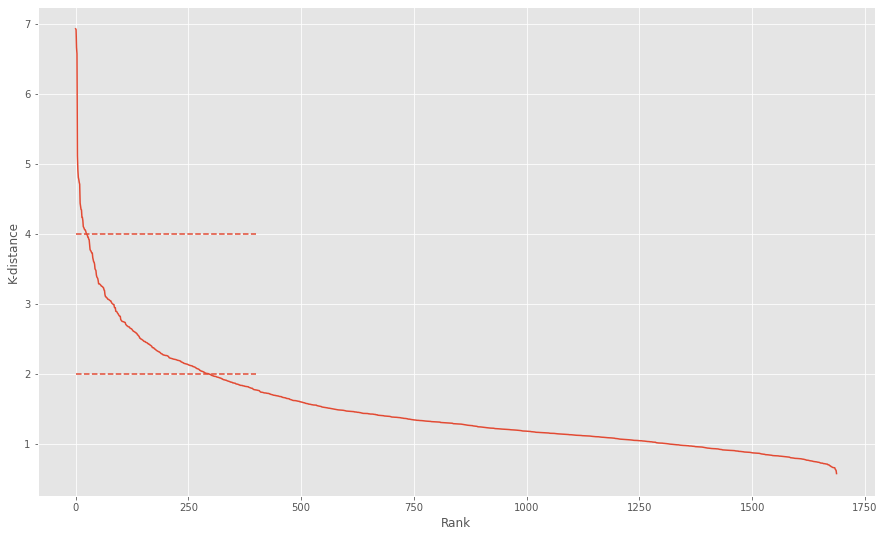

In [370]:
#x3_scaled ratios
minPts=20;
k=minPts-1;

D=squareform(pdist(x3_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

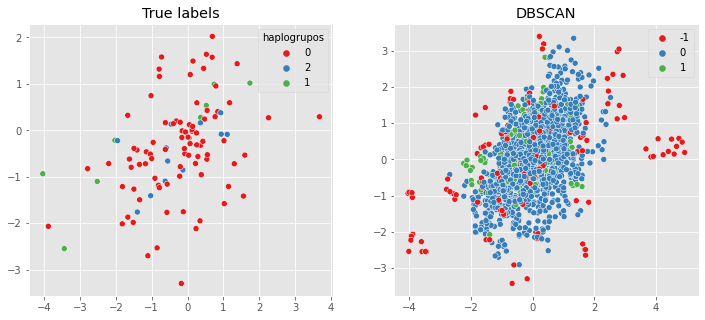

In [371]:
#x3_scaled ratios
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x3_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x3_scaled[:,0], y = x3_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');

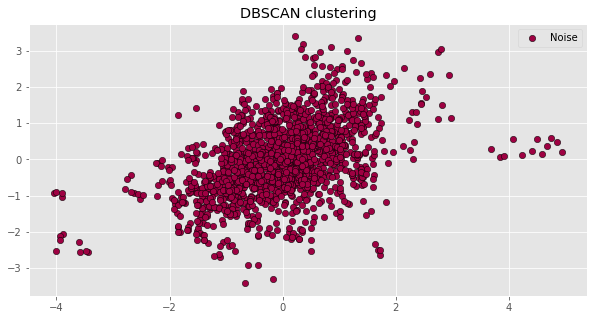

In [372]:
#x3_scaled ratios
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x3_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x3_scaled[labels==l,0], x3_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x3_scaled[labels==l,0], x3_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

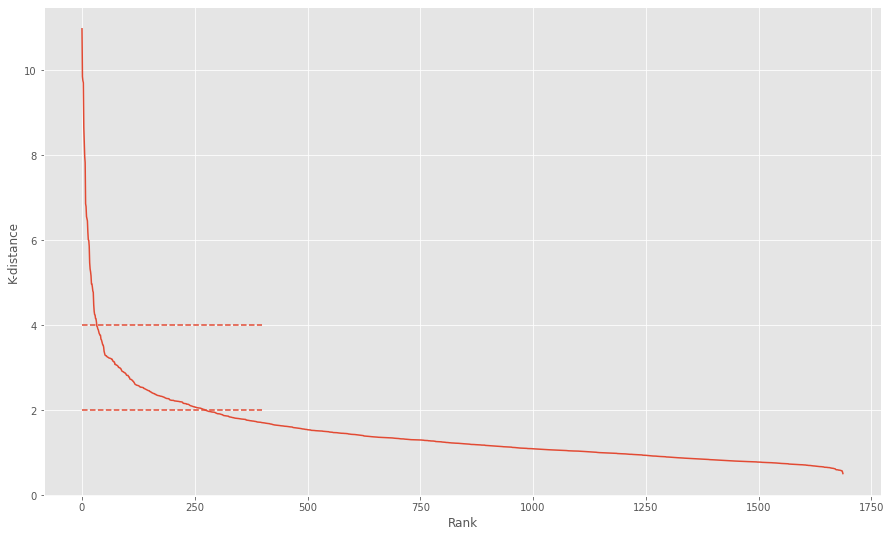

In [373]:
#x4_scaled power ratios
minPts=20;
k=minPts-1;

D=squareform(pdist(x4_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

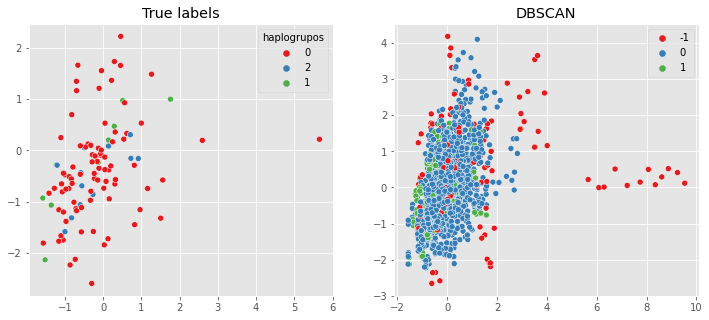

In [374]:
#x4_scaled power ratios
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x4_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x4_scaled[:,0], y = x4_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN');

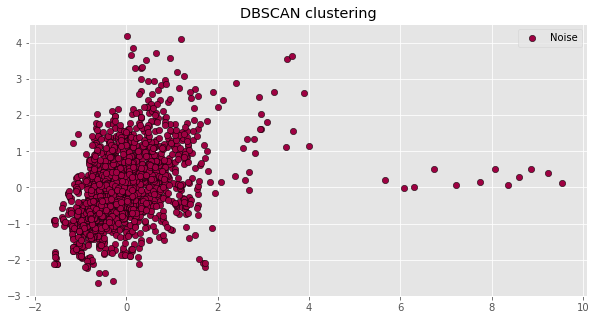

In [375]:
#x4_scaled powers ratios
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x4_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x4_scaled[labels==l,0], x4_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x4_scaled[labels==l,0], x4_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

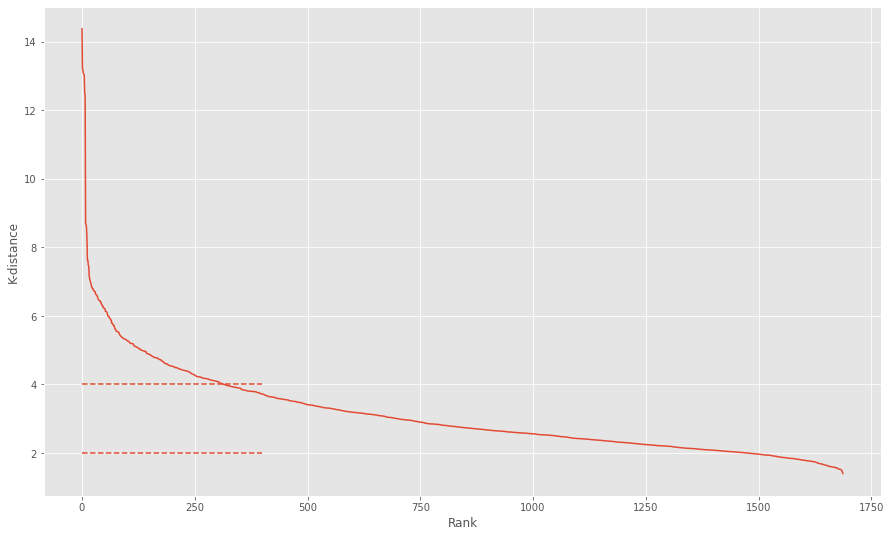

In [376]:
#x5_scaled todos
minPts=20;
k=minPts-1;

D=squareform(pdist(x5_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'DBSCAN')

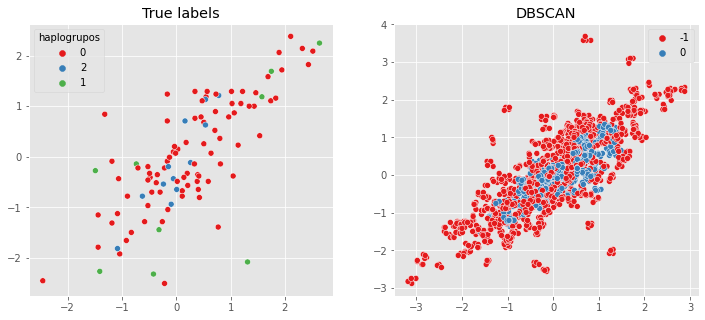

In [377]:
#x5_scaled todos
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x5_scaled)

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x5_scaled[:,0], y = x5_scaled[:,1],hue=labels_db,ax=ax[1], palette="Set1")
ax[1].set_title('DBSCAN')

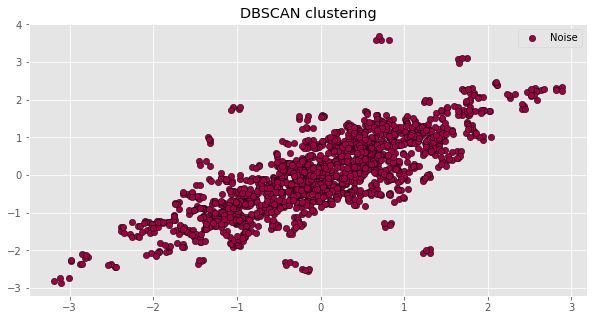

In [378]:
#x5_scaled todos
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x5_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x5_scaled[labels==l,0], x5_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x5_scaled[labels==l,0], x5_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');

# Modelos reducción dimensionalidad

## Prueba PCA

In [379]:
from sklearn.decomposition import PCA

### Data frames

In [380]:
df_x1 = pd.DataFrame(x1_scaled, index = x1.index, columns = x1.columns)
df_x2 = pd.DataFrame(x2_scaled, index = x2.index, columns = x2.columns)
df_x3 = pd.DataFrame(x3_scaled, index = x3.index, columns = x3.columns)
df_x4 = pd.DataFrame(x4_scaled, index = x4.index, columns = x4.columns)
df_x5 = pd.DataFrame(x5_scaled, index = x5.index, columns = x5.columns)

In [381]:
pca_1 = PCA().fit(df_x1)
pca_2 = PCA().fit(df_x2)
pca_3 = PCA().fit(df_x3)
pca_4 = PCA().fit(df_x4)
pca_5 = PCA().fit(df_x5)

### Pesos (loadings)

In [382]:
#x1 medidas
#Creamos un DataFrame con los loadings.
loadings_1 = pd.DataFrame(pca_1.components_.T, index=df_x1.columns, columns = ['PC' + str(x+1) for x in range(0, len(df_x1.columns))])
loadings_1

PC1       PC2       PC3       PC4       PC5       PC6  \
AE            0.401108  0.002964 -0.088953  0.050613 -0.151504 -0.795708   
LE            0.336554 -0.053072 -0.604906  0.585563  0.265920  0.240136   
AT            0.401806  0.044061  0.225250  0.034191 -0.314269 -0.095487   
LT            0.409534  0.045337  0.046567  0.122126  0.019045  0.008085   
AA            0.391797  0.012194  0.254054  0.037390 -0.511167  0.524678   
LA            0.351494  0.104381  0.524742 -0.068194  0.732193  0.057296   
NV            0.344338 -0.084260 -0.461553 -0.793037  0.091453  0.140441   
Morfotipo_LB -0.021860  0.698766 -0.095491  0.006874 -0.015253 -0.012856   
Morfotipo_LU  0.024047 -0.697682  0.105938  0.058879  0.034808 -0.039248   

                   PC7       PC8       PC9  
AE            0.047696  0.113803 -0.396607  
LE            0.213225 -0.031705 -0.016443  
AT            0.432310 -0.262768  0.648754  
LT           -0.824665  0.138649  0.336777  
AA            0.024623  0.086082 -0.485603  
LA            0.158837  0.003624 -0.144640  
NV            0.024735 -0.057488  0.019710  
Morfotipo_LB -0.160527 -0.667604 -0.173839  
Morfotipo_LU -0.181875 -0.664341 -0.144196

In [383]:
#x2 powers
#Creamos un DataFrame con los loadings.
loadings_2 = pd.DataFrame(pca_2.components_.T, index=df_x2.columns, columns = ['PC' + str(x+1) for x in range(0, len(df_x2.columns))])
loadings_2

PC1       PC2       PC3       PC4       PC5       PC6  \
Power_LE      0.322896 -0.050672  0.619972  0.612948  0.241434  0.233010   
Power_AE      0.405611 -0.002610  0.085529  0.036679 -0.162120 -0.816336   
Power_LT      0.416037  0.035421 -0.060088  0.092648 -0.085528 -0.027791   
Power_AT      0.408467  0.044697 -0.239536  0.029140 -0.249415  0.010913   
Power_LA      0.359498  0.080114 -0.444714 -0.081548  0.796900  0.037277   
Power_AA      0.395103  0.009684 -0.285064  0.044126 -0.454935  0.497819   
Power_NV      0.325316 -0.116999  0.497819 -0.774752  0.056067  0.163555   
Morfotipo_LB -0.005783  0.698379  0.097095 -0.016798 -0.018276 -0.015957   
Morfotipo_LU  0.008748 -0.697309 -0.105114  0.066309  0.020256 -0.046816   

                   PC7       PC8       PC9  
Power_LE     -0.141563  0.021776 -0.001399  
Power_AE     -0.203986 -0.287860 -0.098244  
Power_LT      0.886181  0.031751  0.138027  
Power_AT     -0.302331  0.745911  0.250631  
Power_LA     -0.103746 -0.099719 -0.052685  
Power_AA     -0.185979 -0.468752 -0.226904  
Power_NV     -0.019716  0.036762 -0.027979  
Morfotipo_LB  0.075403  0.240337 -0.662184  
Morfotipo_LU  0.101011  0.265492 -0.644164

In [384]:
#x3 ratios
#Creamos un DataFrame con los loadings.
loadings_3 = pd.DataFrame(pca_3.components_.T, index=df_x3.columns, columns = ['PC' + str(x+1) for x in range(0, len(df_x3.columns))])
loadings_3

PC1       PC2       PC3       PC4       PC5       PC6  \
Ratio_LE_AE   0.376385 -0.028108  0.156474 -0.225953  0.534562  0.073327   
Ratio_LT_AT   0.242198  0.111639  0.148333 -0.700756 -0.287576  0.403178   
Ratio_LA_AA  -0.219181  0.437033 -0.203860 -0.431263  0.239438  0.028547   
Ratio_LE_LT   0.430695  0.047586  0.029088  0.008317  0.393402 -0.321331   
Ratio_AE_AT   0.339766  0.254681 -0.147273 -0.071144 -0.465429 -0.482171   
Ratio_LA_LT  -0.387550  0.123540 -0.152783 -0.286293  0.293036 -0.514066   
Ratio_AA_AT   0.012657 -0.493869  0.283407 -0.349293 -0.238654 -0.463392   
Ratio_LE_LA   0.467036 -0.016545  0.080670  0.137835  0.144065 -0.026975   
Ratio_AE_AA   0.235543  0.482496 -0.277948  0.146086 -0.195691 -0.064152   
Morfotipo_LB -0.114547  0.346054  0.591962  0.100353 -0.022647 -0.067588   
Morfotipo_LU  0.116690 -0.341501 -0.592938 -0.111304  0.020853  0.084293   

                   PC7       PC8       PC9      PC10      PC11  
Ratio_LE_AE   0.010336 -0.458349  0.521433 -0.040644 -0.084483  
Ratio_LT_AT   0.000870  0.150030 -0.104709 -0.155710  0.335922  
Ratio_LA_AA   0.016818  0.089585 -0.185569  0.305392 -0.582461  
Ratio_LE_LT   0.001578 -0.080348 -0.706347  0.005423  0.218836  
Ratio_AE_AT  -0.008662 -0.168974  0.089832 -0.442117 -0.334168  
Ratio_LA_LT  -0.023246  0.261103  0.259953 -0.246545  0.426647  
Ratio_AA_AT   0.011202 -0.026240  0.042148  0.522436 -0.079932  
Ratio_LE_LA  -0.020326  0.801890  0.233824  0.057284 -0.182264  
Ratio_AE_AA   0.014603 -0.108614  0.227234  0.589560  0.399354  
Morfotipo_LB -0.707628 -0.020421 -0.003113  0.019407 -0.003759  
Morfotipo_LU -0.705338 -0.016392 -0.006405  0.019443 -0.008157

In [385]:
#x4 powers_ratios
#Creamos un DataFrame con los loadings.
loadings_4 = pd.DataFrame(pca_4.components_.T, index=df_x4.columns, columns = ['PC' + str(x+1) for x in range(0, len(df_x4.columns))])
#loadings_4

In [386]:
#x5 todos
#Creamos un DataFrame con los loadings.
loadings_5 = pd.DataFrame(pca_5.components_.T, index=df_x5.columns, columns = ['PC' + str(x+1) for x in range(0, len(df_x5.columns))])
#loadings_5

### Explicación Varianza

In [387]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

[0.63691166 0.22227471 0.07150333 0.02924664 0.01859941 0.01113719
 0.00416907 0.00318363 0.00297435]


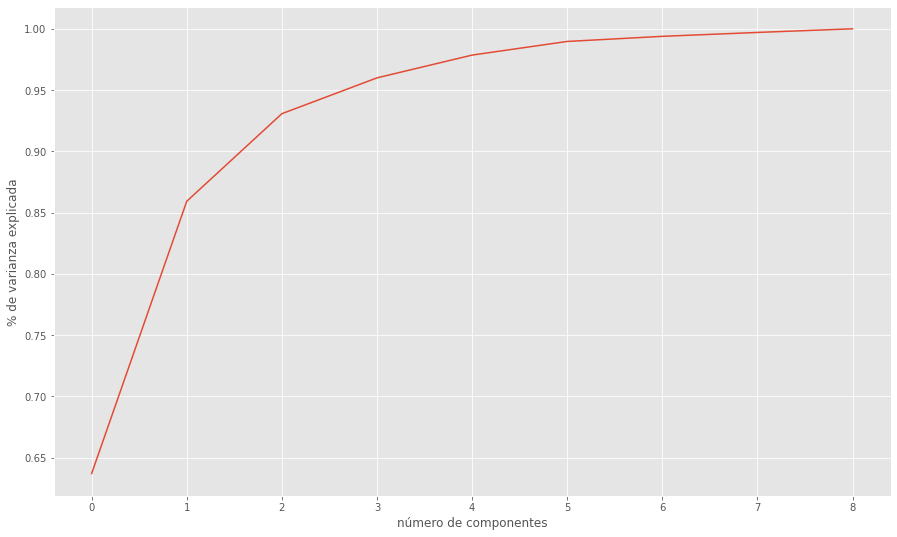

In [388]:
plot_explained_variance(components_count = len(df_x1.columns), X = df_x1)

[0.61229071 0.22291005 0.07729284 0.0394463  0.0234383  0.01292552
 0.00507918 0.00344407 0.00317303]


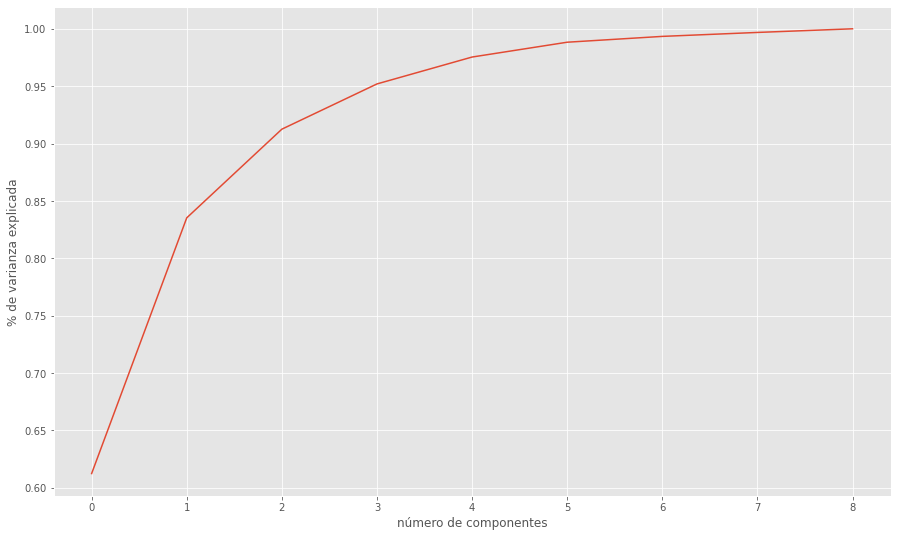

In [389]:
plot_explained_variance(components_count = len(df_x2.columns), X = df_x2)

[3.91625655e-01 2.17978526e-01 1.63000644e-01 9.89898637e-02
 9.01444436e-02 3.39964209e-02 2.69499496e-03 8.82840067e-04
 3.05715941e-04 2.70429976e-04 1.10466357e-04]


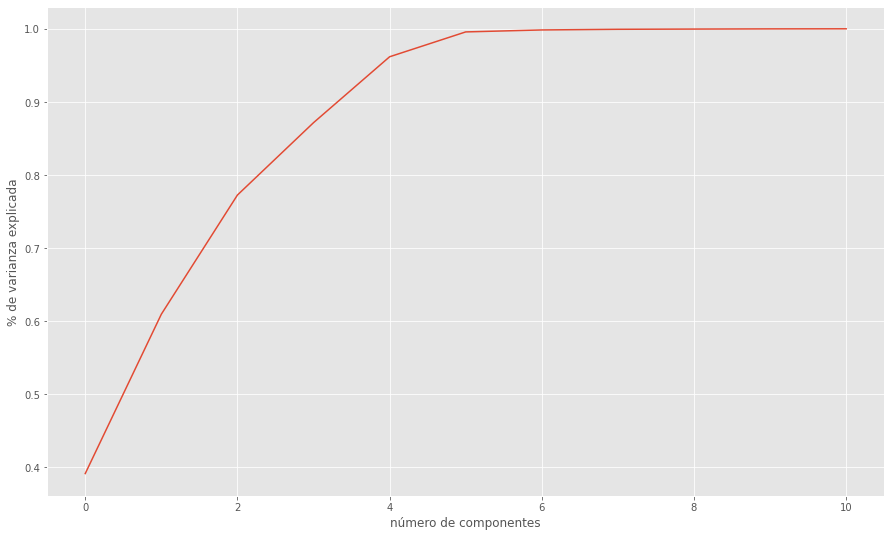

In [390]:
plot_explained_variance(components_count = len(df_x3.columns), X = df_x3)

[0.35067269 0.21746512 0.16128571 0.10788445 0.09816497 0.0393965
 0.01154897 0.00467711 0.00432097 0.00267022 0.00191328]


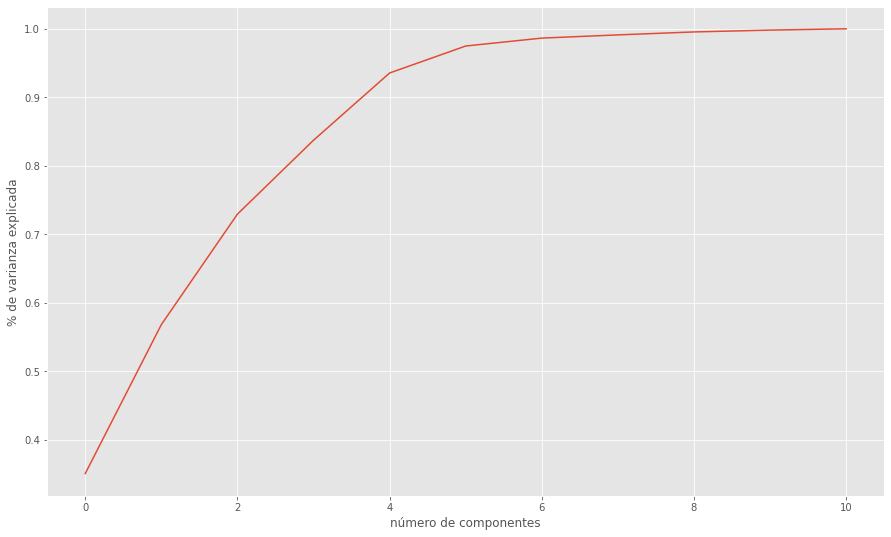

In [391]:
plot_explained_variance(components_count = len(df_x4.columns), X = df_x4)

[3.70213849e-01 2.32283588e-01 1.30964136e-01 7.38963378e-02
 6.61507528e-02 5.53478832e-02 2.44482716e-02 1.84468979e-02
 7.36983641e-03 5.04681899e-03 3.63046376e-03 3.42268560e-03
 2.08024091e-03 1.45949548e-03 1.29842474e-03 8.77983390e-04
 8.35753327e-04 7.05679134e-04 3.68430504e-04 2.86383605e-04
 2.29947693e-04 2.14834401e-04 1.63564729e-04 1.34301329e-04
 6.02276401e-05 2.91482480e-05 1.44292140e-05 6.30058106e-06
 5.29583036e-06 3.45797090e-06 1.60849340e-06 1.29052300e-06
 1.00719865e-06 6.73832881e-07]


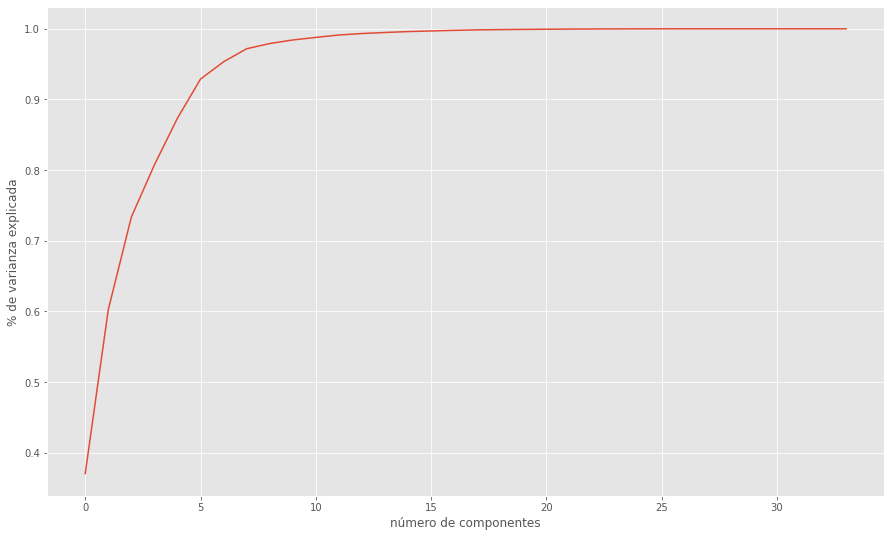

In [392]:
plot_explained_variance(components_count = len(df_x5.columns), X = df_x5)

### Proyección - Bastón Quebrado

In [393]:
df_pca_1 = pd.DataFrame(PCA().fit_transform(df_x1), columns = ['PC' + str(x+1) for x in range(0, len(df_x1.columns))], index = df_x1.index)
df_pca_haplo_1 = pd.concat([df_pca_1, data["haplogrupos"]], axis = 1)

df_pca_2 = pd.DataFrame(PCA().fit_transform(df_x2), columns = ['PC' + str(x+1) for x in range(0, len(df_x2.columns))], index = df_x2.index)
df_pca_haplo_2 = pd.concat([df_pca_2, data["haplogrupos"]], axis = 1)

df_pca_3 = pd.DataFrame(PCA().fit_transform(df_x3), columns = ['PC' + str(x+1) for x in range(0, len(df_x3.columns))], index = df_x3.index)
df_pca_haplo_3 = pd.concat([df_pca_3, data["haplogrupos"]], axis = 1)

df_pca_4 = pd.DataFrame(PCA().fit_transform(df_x4), columns = ['PC' + str(x+1) for x in range(0, len(df_x4.columns))], index = df_x4.index)
df_pca_haplo_4 = pd.concat([df_pca_4, data["haplogrupos"]], axis = 1)

df_pca_5 = pd.DataFrame(PCA().fit_transform(df_x5), columns = ['PC' + str(x+1) for x in range(0, len(df_x5.columns))], index = df_x5.index)
df_pca_haplo_5 = pd.concat([df_pca_5, data["haplogrupos"]], axis = 1)

#### Proyección - Bastón Quebrado (x1 - Medidas)

KMeans(n_clusters=3, random_state=0)

Text(0.5, 0, 'PC1')

Text(0.5, 0, 'PC2')

Text(0.5, 0, 'PC3')

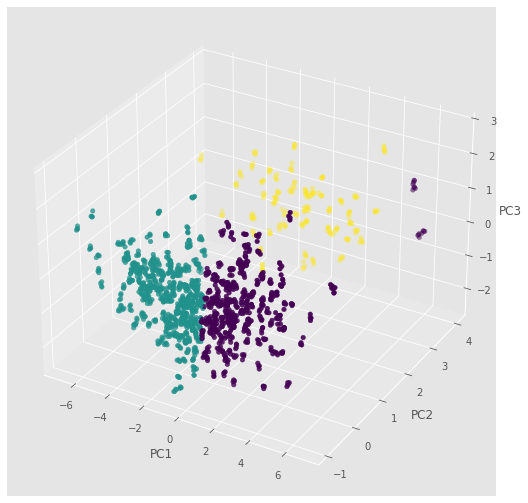

In [412]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(df_pca_1)

labels = kmeans.labels_ 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(df_pca_1["PC1"], df_pca_1["PC2"], df_pca_1["PC3"], c = labels)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

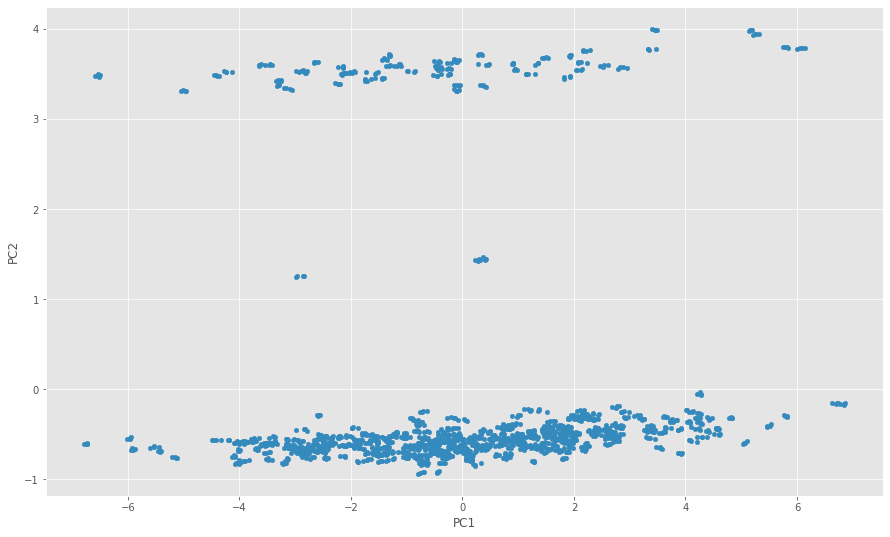

In [413]:
df_pca_1.plot(x="PC1", y="PC2", kind ="scatter")

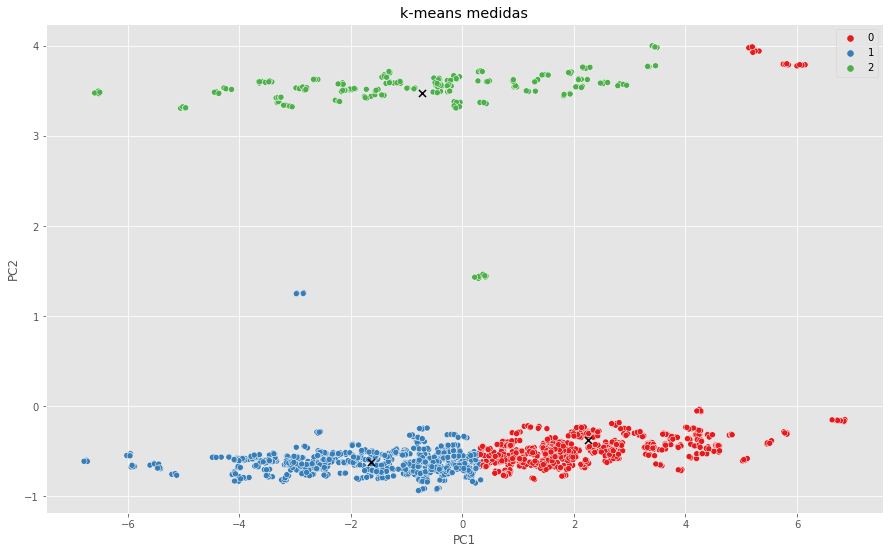

In [395]:
#x1_scaled medidas
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(df_pca_1)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=df_pca_haplo_1["PC1"], y=df_pca_haplo_1["PC2"], hue=labels, legend='full', palette = 'Set1');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k'); plt.title('k-means medidas');

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

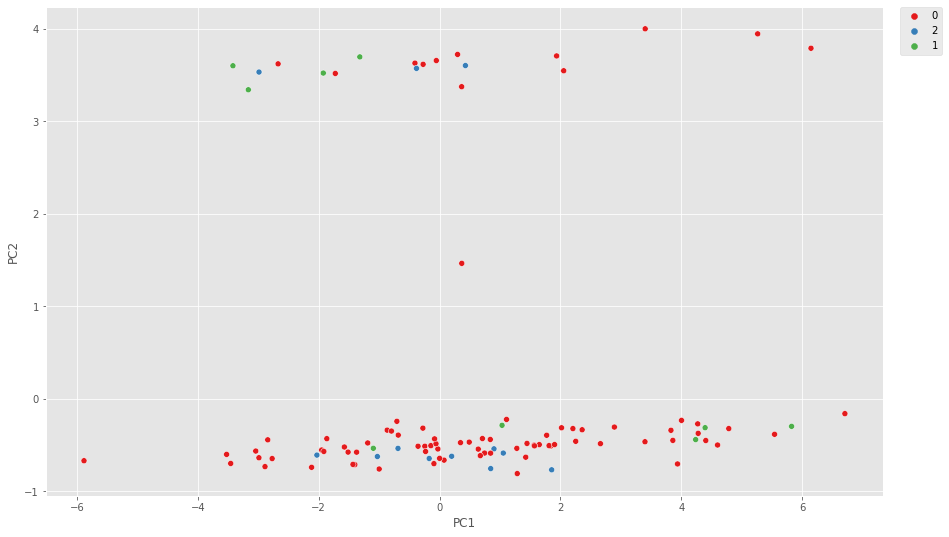

In [396]:
sns.scatterplot(data=df_pca_haplo_1, x="PC1", y="PC2", hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

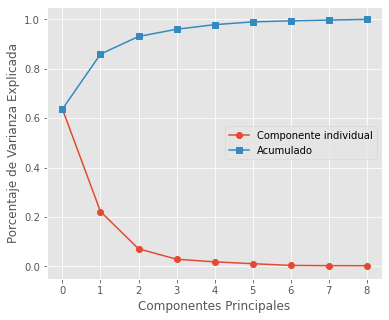

In [397]:
plt.figure(figsize=(6,5))

plt.plot(pca_1.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_1.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x2 - Powers)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

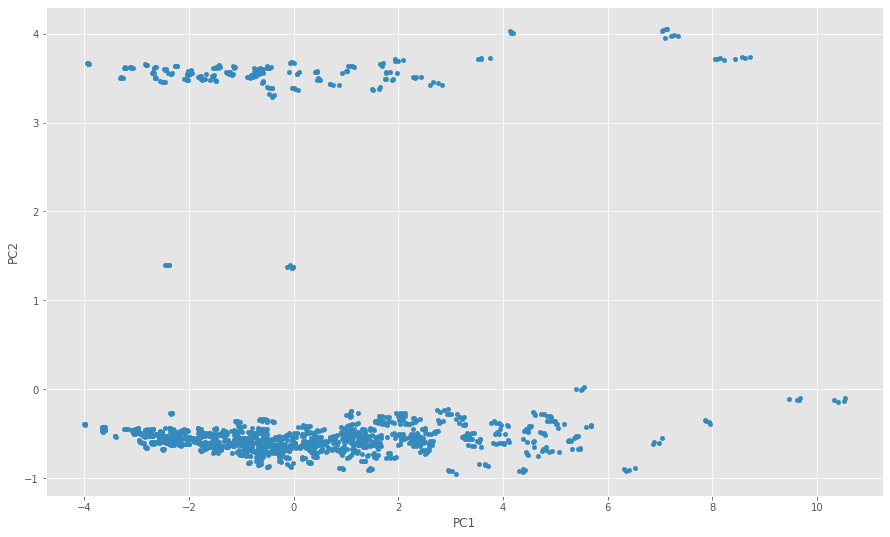

In [248]:
df_pca_2.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

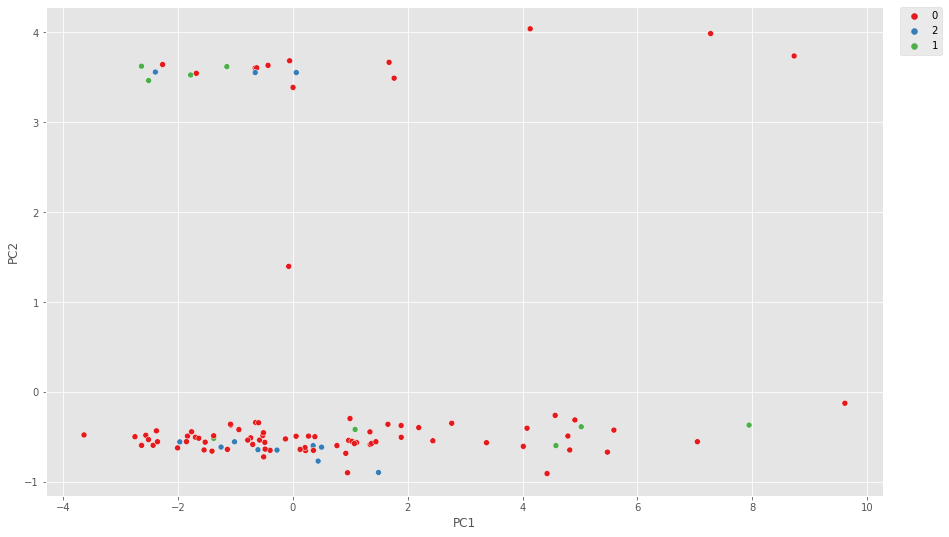

In [249]:
sns.scatterplot(data=df_pca_haplo_2,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

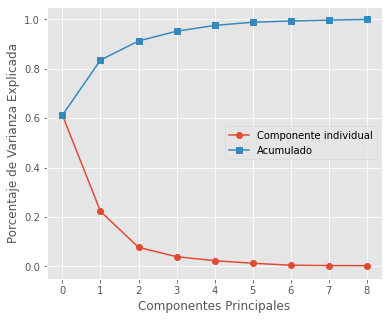

In [250]:
plt.figure(figsize=(6,5))

plt.plot(pca_2.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x3 - Ratios)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

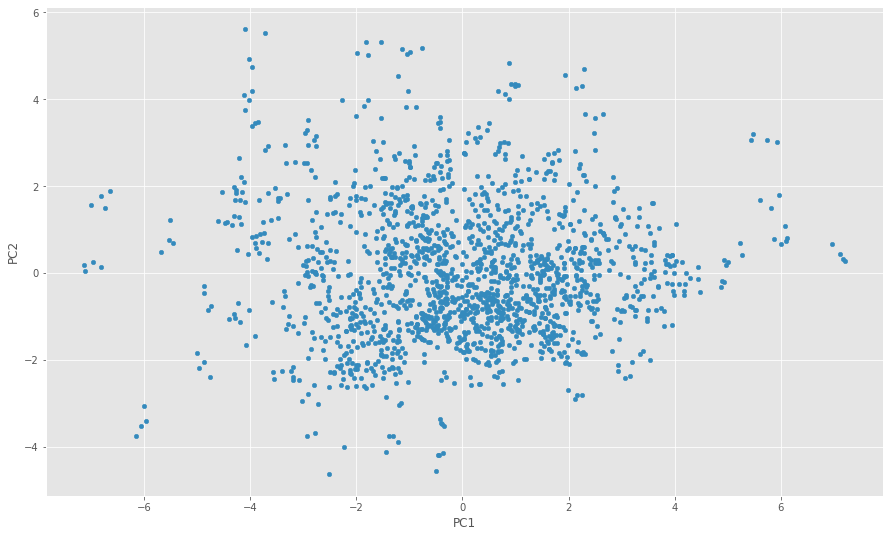

In [251]:
df_pca_3.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

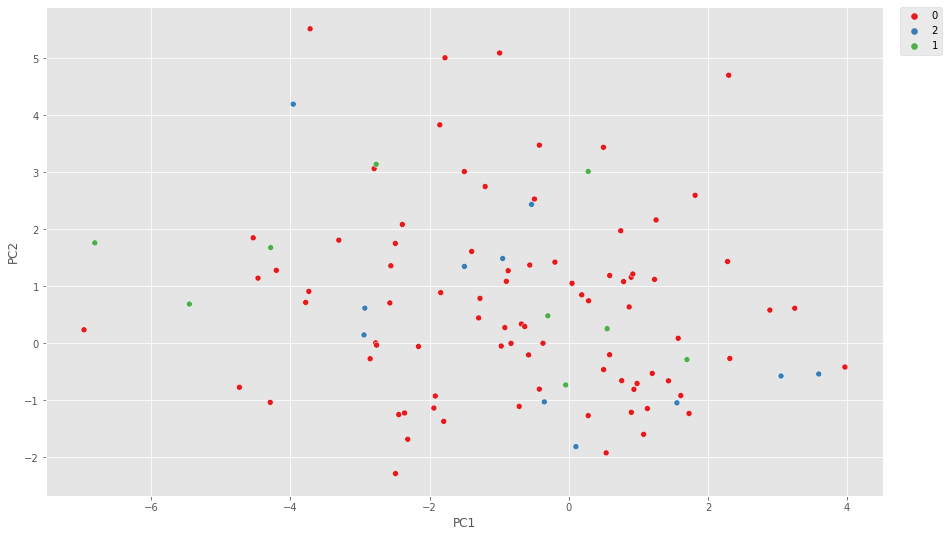

In [252]:
sns.scatterplot(data=df_pca_haplo_3,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

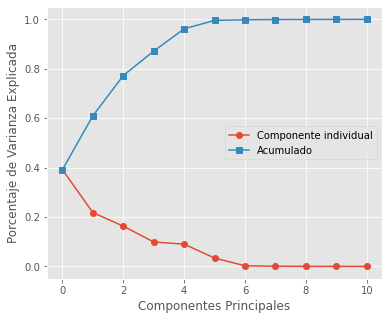

In [253]:
plt.figure(figsize=(6,5))

plt.plot(pca_3.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_3.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x4 - Power Ratios)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

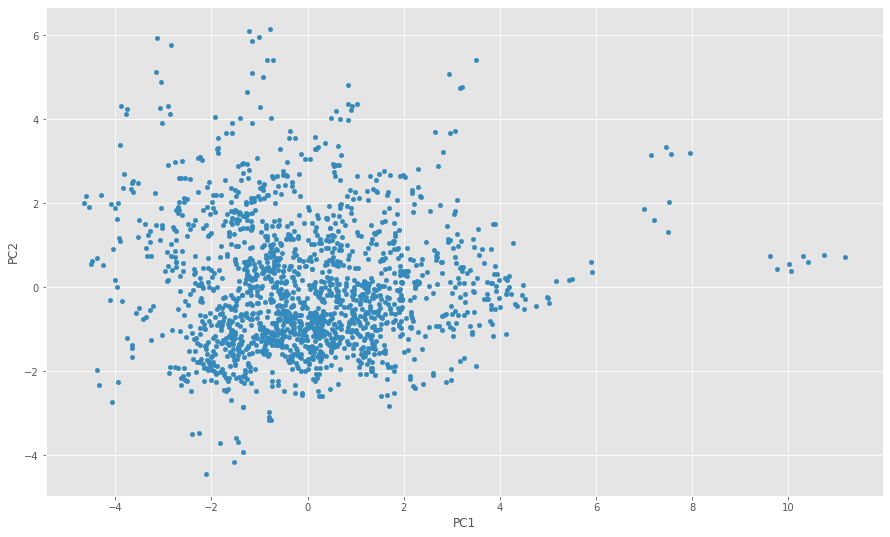

In [254]:
df_pca_4.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

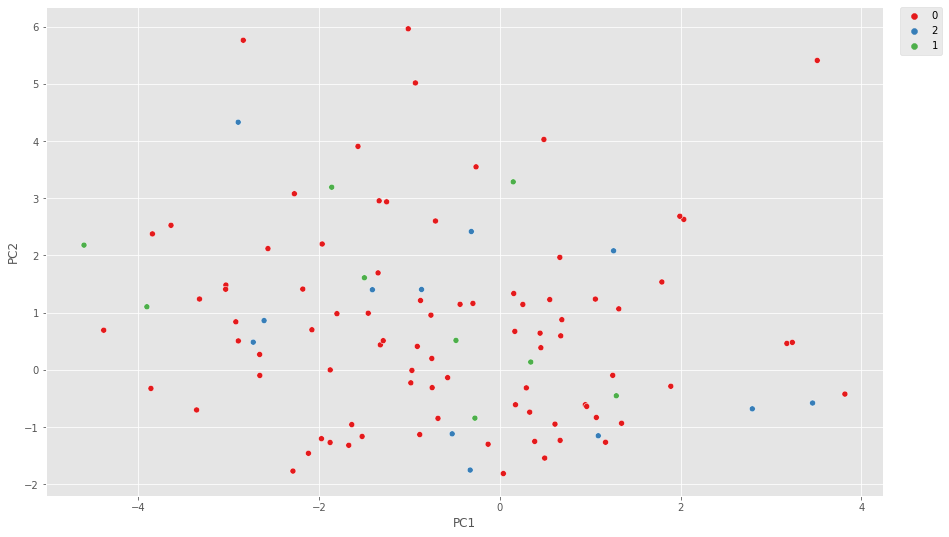

In [255]:
sns.scatterplot(data=df_pca_haplo_4,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

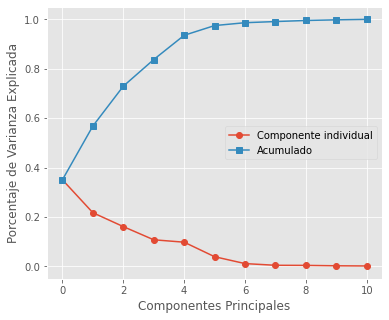

In [256]:
plt.figure(figsize=(6,5))

plt.plot(pca_4.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_4.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

#### Proyección - Bastón Quebrado (x5 - Todos los futures)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

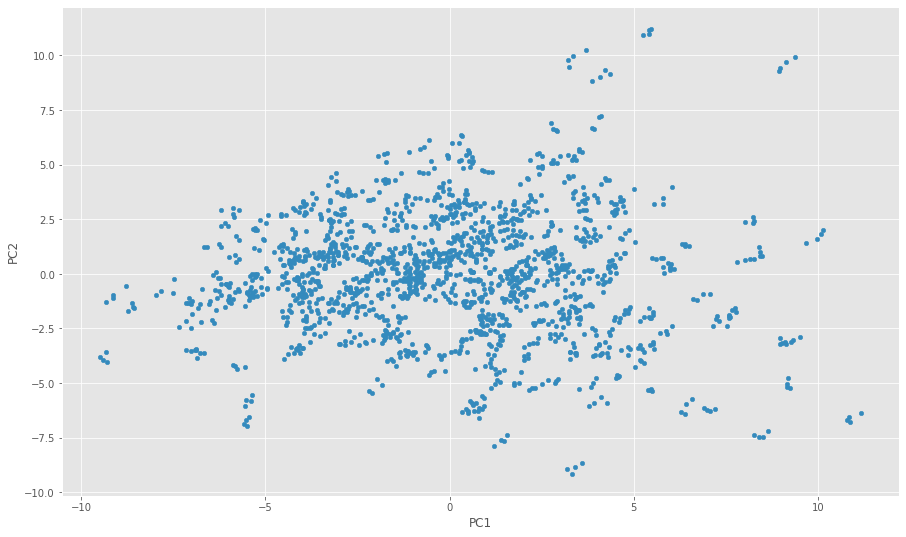

In [257]:
df_pca_5.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

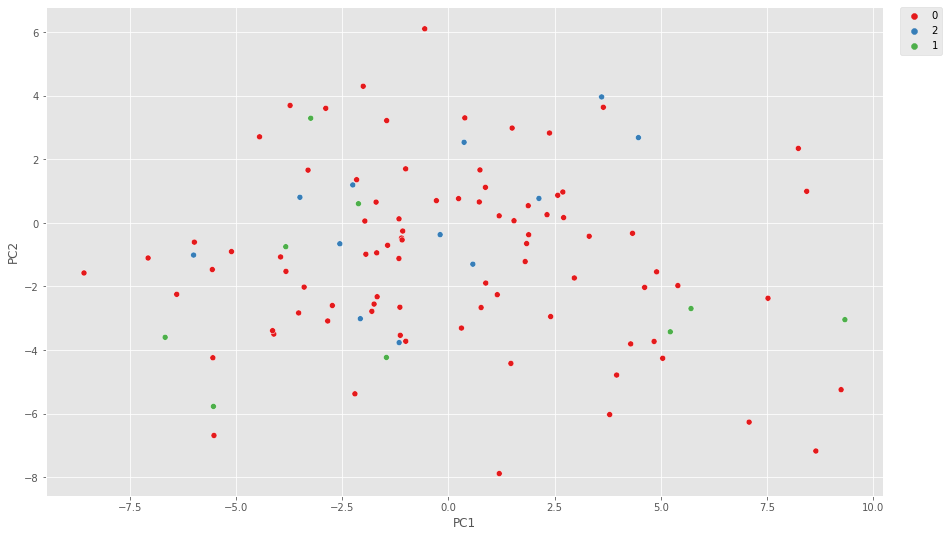

In [258]:
sns.scatterplot(data=df_pca_haplo_5,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

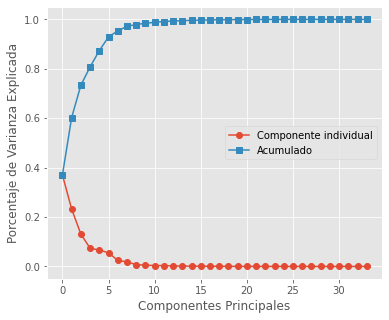

In [259]:
plt.figure(figsize=(6,5))

plt.plot(pca_5.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca_5.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

## Prueba TSNE

In [260]:
from sklearn.manifold import TSNE

### TSNE (x1 - Medidas)

In [261]:
tsne = TSNE(random_state=42)

proj_tsne_x1 =  tsne.fit_transform(df_x1)

In [262]:
df_x1.head()

AE        LE        AT        LT        AA        LA        NV
0 -0.165818  1.238365  0.391905  0.495167  0.321955  0.760541  0.454609
1 -0.624470 -0.779665 -0.843994 -1.029964 -1.064153 -0.442926 -0.584837
2 -0.104664  0.016926  0.258016  0.119107  0.427331 -0.180352 -0.115410
3  0.364181  1.158706 -0.756451 -0.354450 -0.918247 -1.438522  0.991097
4 -0.176010  1.264918  0.314661  0.495167  0.475967  0.837125  0.488139

In [263]:
df_tsne_x1= pd.DataFrame(proj_tsne_x1)

In [264]:
df_tsne_x1.head()

0          1
0 -39.723125  -1.072387
1  42.875477   2.316297
2  -3.300494   4.378702
3  -5.048766 -36.491467
4 -39.910183  -0.987199

In [265]:
tsne_haplo_x1= pd.concat([df_tsne_x1, data["haplogrupos"]], axis=1)

In [266]:
tsne_haplo_x1.columns = ["X","Y","haplogrupos"]

In [267]:
tsne_haplo_x1.head()

X          Y haplogrupos
0 -39.723125  -1.072387           0
1  42.875477   2.316297           2
2  -3.300494   4.378702         NaN
3  -5.048766 -36.491467         NaN
4 -39.910183  -0.987199         NaN

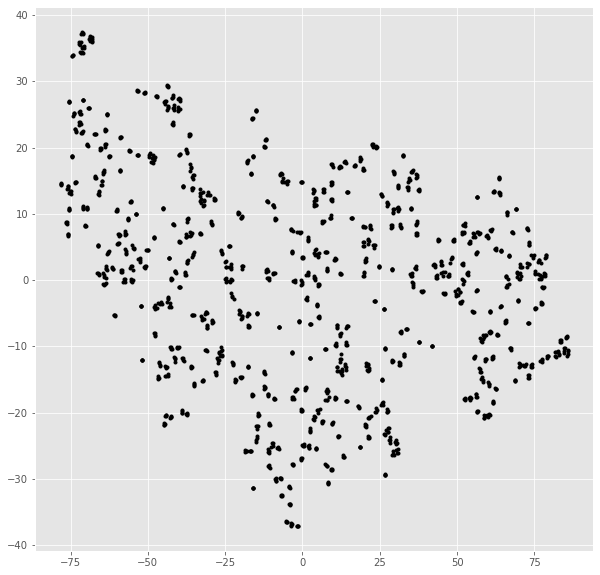

In [268]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x1[:, 0]
coord_y = proj_tsne_x1[:, 1]
ax.plot(coord_x, coord_y, '.k')

<AxesSubplot:xlabel='X', ylabel='Y'>

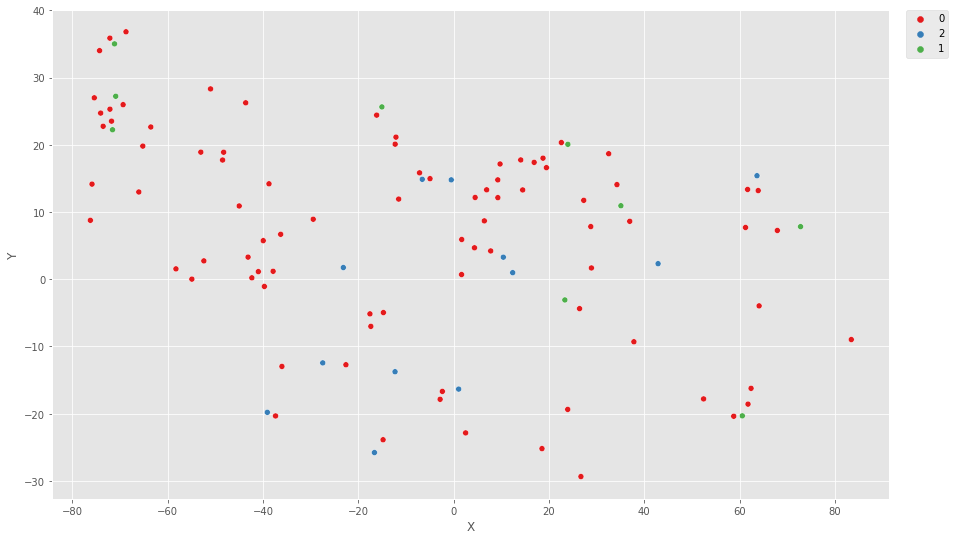

In [269]:
sns.scatterplot(data=tsne_haplo_x1,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x2 - Powers)

In [270]:
tsne = TSNE(random_state=42)

proj_tsne_x2 = tsne.fit_transform(df_x2)

In [271]:
df_x2.head()

Power_LE  Power_AE  Power_LT  Power_AT  Power_LA  Power_AA  Power_NV  \
0  1.154010 -0.357865  0.282269  0.175066  0.521446  0.080256  0.393611   
1 -0.726906 -0.700299 -0.907626 -0.806395 -0.501737 -0.892336 -0.652027   
2 -0.244439 -0.306054 -0.090606  0.041019 -0.321729  0.184689 -0.203236   
3  1.031730  0.144643 -0.481210 -0.753926 -1.009074 -0.820114  1.010564   
4  1.195883 -0.366353  0.282269  0.096814  0.605445  0.234591  0.430566   

   Morfotipo_LB  Morfotipo_LU  
0     -0.391159      0.403156  
1     -0.391159      0.403156  
2     -0.391159      0.403156  
3     -0.391159      0.403156  
4     -0.391159      0.403156

In [272]:
df_tsne_x2= pd.DataFrame(proj_tsne_x2)

In [273]:
df_tsne_x2.head()

0          1
0 -21.470926  22.143183
1  42.815845 -15.714681
2   8.764060   5.574784
3 -14.573481 -14.703093
4 -21.612427  22.221329

In [274]:
tsne_haplo_x2= pd.concat([df_tsne_x2, data["haplogrupos"]], axis=1)

In [275]:
tsne_haplo_x2.columns = ["X","Y","haplogrupos"]

In [276]:
tsne_haplo_x2.head()

X          Y haplogrupos
0 -21.470926  22.143183           0
1  42.815845 -15.714681           2
2   8.764060   5.574784         NaN
3 -14.573481 -14.703093         NaN
4 -21.612427  22.221329         NaN

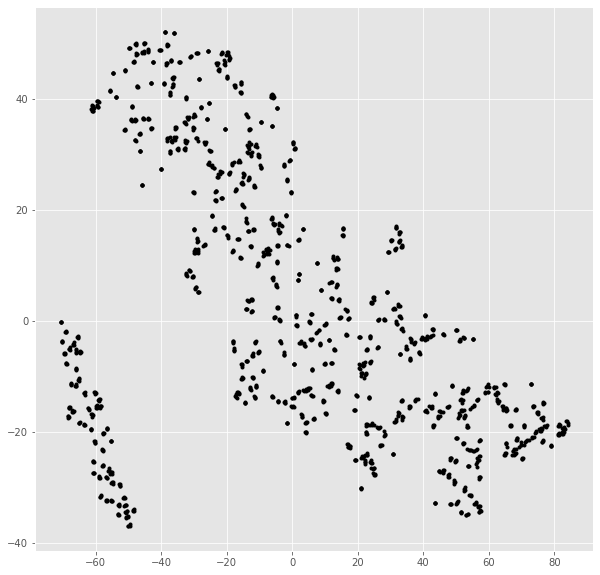

In [277]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x2[:, 0]
coord_y = proj_tsne_x2[:, 1]
ax.plot(coord_x, coord_y, '.k')

<AxesSubplot:xlabel='X', ylabel='Y'>

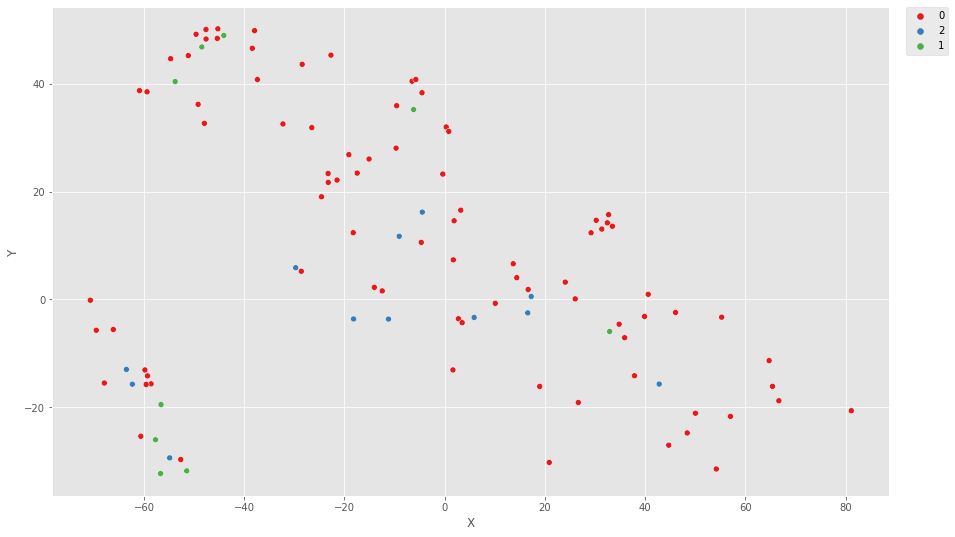

In [278]:
sns.scatterplot(data=tsne_haplo_x2,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x3 - Ratios)

In [279]:
tsne = TSNE(random_state=42)

proj_tsne_x3  = tsne.fit_transform(df_x3)

In [280]:
df_x3.head()

Ratio_LE_AE  Ratio_LT_AT  Ratio_LA_AA  Ratio_LE_LT  Ratio_AE_AT  \
0     2.256107     0.269761     0.516143     1.322856    -1.280251   
1    -0.554716    -0.660628     1.262376    -0.106359     0.474539   
2     0.168034    -0.416794    -1.000452    -0.074893    -0.846540   
3     1.366566     1.306771    -0.840354     2.319632     3.076478   
4     2.315999     0.490792     0.371351     1.361262    -1.143191   

   Ratio_LA_LT  Ratio_AA_AT  Ratio_LE_LA  Ratio_AE_AA  Morfotipo_LB  \
0     0.380014    -0.092006     0.679067    -0.912693     -0.391159   
1     1.176758    -1.049702    -0.587305     0.988954     -0.391159   
2    -0.564496     0.602295     0.128477    -0.979323     -0.391159   
3    -2.045869    -0.798635     2.937666     2.785311     -0.391159   
4     0.505009     0.588356     0.646876    -1.180774     -0.391159   

   Morfotipo_LU  
0      0.403156  
1      0.403156  
2      0.403156  
3      0.403156  
4      0.403156

In [281]:
df_tsne_x3= pd.DataFrame(proj_tsne_x3)

In [282]:
df_tsne_x3.head()

0          1
0  -6.140574   0.161147
1  13.714659 -22.309267
2   4.166580  39.508991
3 -49.990147   5.380136
4  -6.381485  -0.147332

In [283]:
tsne_haplo_x3= pd.concat([df_tsne_x3, data["haplogrupos"]], axis=1)

In [284]:
tsne_haplo_x3.columns = ["X","Y","haplogrupos"]

In [285]:
tsne_haplo_x3.head()

X          Y haplogrupos
0  -6.140574   0.161147           0
1  13.714659 -22.309267           2
2   4.166580  39.508991         NaN
3 -49.990147   5.380136         NaN
4  -6.381485  -0.147332         NaN

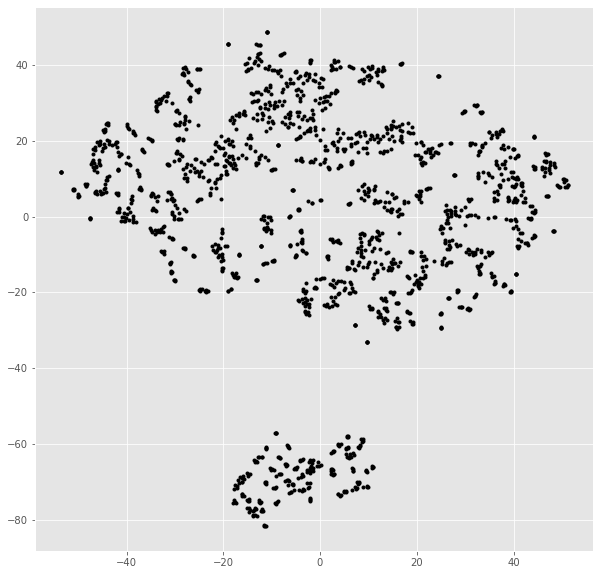

In [286]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x3[:, 0]
coord_y = proj_tsne_x3[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

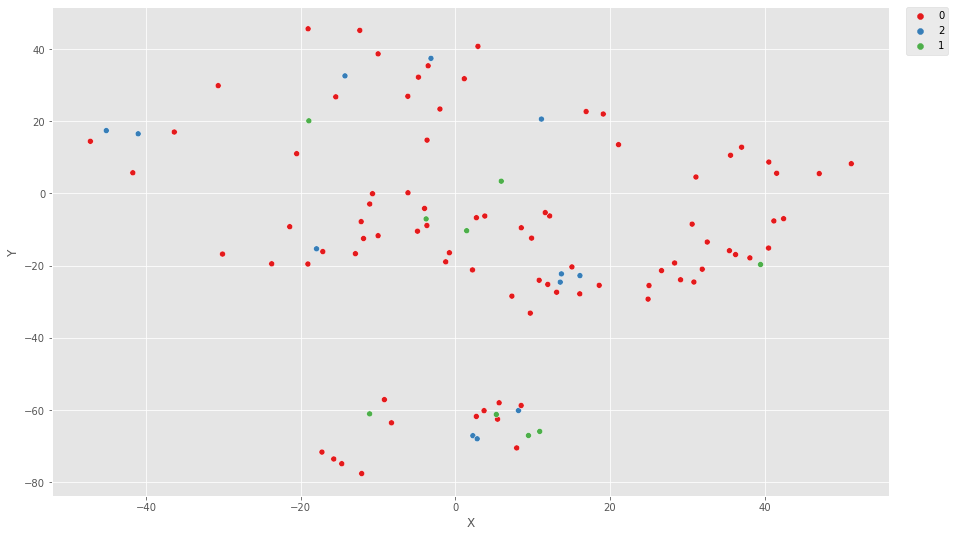

In [287]:
sns.scatterplot(data=tsne_haplo_x3,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x4 - Power Ratios)

In [288]:
tsne = TSNE(random_state=42)

proj_tsne_x4 = tsne.fit_transform(df_x4)

In [289]:
df_x4.head()

Power_Ratio_LE_AE  Power_Ratio_LT_AT  Power_Ratio_LA_AA  Power_Ratio_LE_LT  \
0           2.593865           0.196046           0.366347           1.287535   
1          -0.555070          -0.687849           1.222511          -0.266685   
2          -0.026344          -0.468042          -0.911200          -0.241029   
3           1.247298           1.334049          -0.801902           2.946920   
4           2.698876           0.424586           0.219086           1.341693   

   Power_Ratio_AE_AT  Power_Ratio_LA_LT  Power_Ratio_AA_AT  Power_Ratio_LE_LA  \
0          -1.227032           0.244204          -0.163913           0.386974   
1           0.404190           1.114621          -1.023355          -0.599501   
2          -0.873159          -0.591961           0.542784          -0.130316   
3           3.969806          -1.546420          -0.810370           4.657496   
4          -1.118462           0.370191           0.527867           0.352384   

   Power_Ratio_AE_AA  Morfotipo_LB  Morfotipo_LU  
0          -0.891833     -0.391159      0.403156  
1           0.942224     -0.391159      0.403156  
2          -0.941083     -0.391159      0.403156  
3           3.611463     -0.391159      0.403156  
4          -1.084563     -0.391159      0.403156

In [290]:
df_tsne_x4= pd.DataFrame(proj_tsne_x4)

In [291]:
df_tsne_x4.head()

0          1
0 -11.893164  10.720381
1   9.077359  30.481663
2  17.679892 -30.123726
3 -42.478466 -17.042339
4 -11.646595  10.933705

In [292]:
tsne_haplo_x4= pd.concat([df_tsne_x4, data["haplogrupos"]], axis=1)

In [293]:
tsne_haplo_x4.columns = ["X","Y","haplogrupos"]

In [294]:
tsne_haplo_x4.head()

X          Y haplogrupos
0 -11.893164  10.720381           0
1   9.077359  30.481663           2
2  17.679892 -30.123726         NaN
3 -42.478466 -17.042339         NaN
4 -11.646595  10.933705         NaN

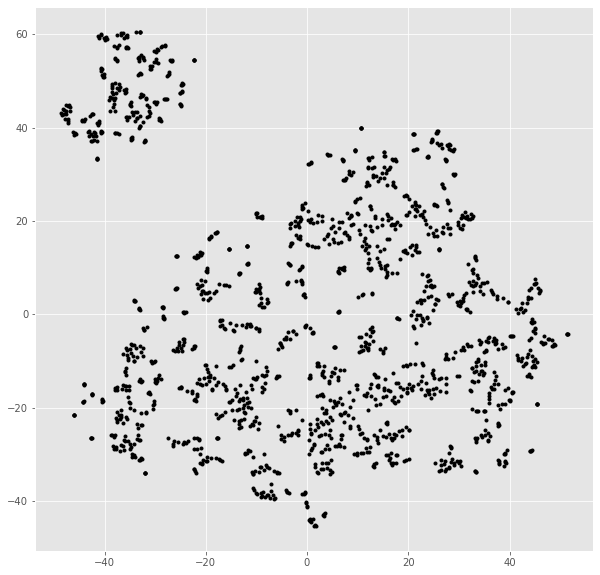

In [295]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x4[:, 0]
coord_y = proj_tsne_x4[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

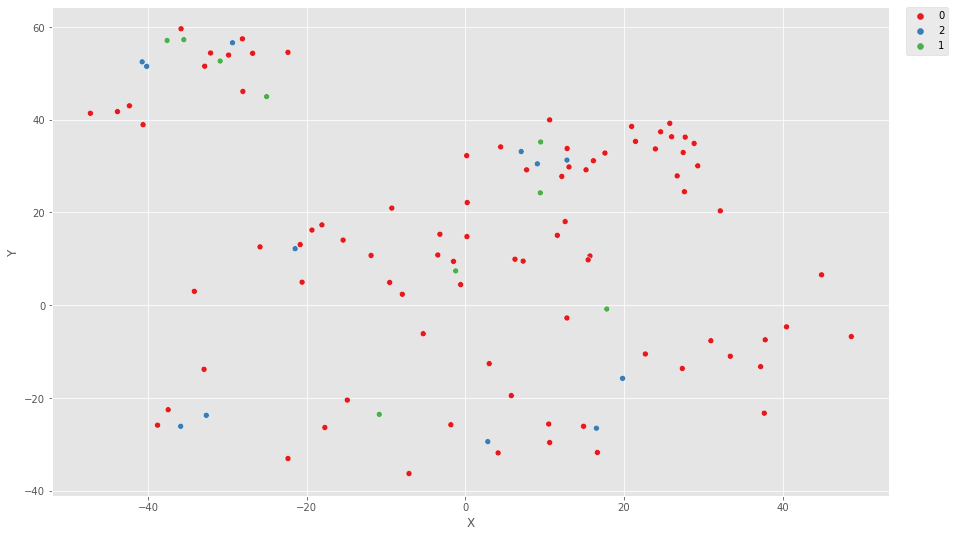

In [296]:
sns.scatterplot(data=tsne_haplo_x4,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### TSNE (x5 - Todas las Futures)

In [297]:
tsne = TSNE(random_state=42)

proj_tsne_x5 = tsne.fit_transform(df_x5)

In [298]:
df_x5.head()

AE        LE        AT        LT        AA        LA        NV  \
0 -0.165818  1.238365  0.391905  0.495167  0.321955  0.760541  0.454609   
1 -0.624470 -0.779665 -0.843994 -1.029964 -1.064153 -0.442926 -0.584837   
2 -0.104664  0.016926  0.258016  0.119107  0.427331 -0.180352 -0.115410   
3  0.364181  1.158706 -0.756451 -0.354450 -0.918247 -1.438522  0.991097   
4 -0.176010  1.264918  0.314661  0.495167  0.475967  0.837125  0.488139   

   Ratio_LE_AE  Ratio_LT_AT  Ratio_LA_AA  ...  Power_NV  Power_Ratio_LE_AE  \
0     2.256107     0.269761     0.516143  ...  0.393611           2.593865   
1    -0.554716    -0.660628     1.262376  ... -0.652027          -0.555070   
2     0.168034    -0.416794    -1.000452  ... -0.203236          -0.026344   
3     1.366566     1.306771    -0.840354  ...  1.010564           1.247298   
4     2.315999     0.490792     0.371351  ...  0.430566           2.698876   

   Power_Ratio_LT_AT  Power_Ratio_LA_AA  Power_Ratio_LE_LT  Power_Ratio_AE_AT  \
0           0.196046           0.366347           1.287535          -1.227032   
1          -0.687849           1.222511          -0.266685           0.404190   
2          -0.468042          -0.911200          -0.241029          -0.873159   
3           1.334049          -0.801902           2.946920           3.969806   
4           0.424586           0.219086           1.341693          -1.118462   

   Power_Ratio_LA_LT  Power_Ratio_AA_AT  Power_Ratio_LE_LA  Power_Ratio_AE_AA  
0           0.244204          -0.163913           0.386974          -0.891833  
1           1.114621          -1.023355          -0.599501           0.942224  
2          -0.591961           0.542784          -0.130316          -0.941083  
3          -1.546420          -0.810370           4.657496           3.611463  
4           0.370191           0.527867           0.352384          -1.084563  

[5 rows x 34 columns]

In [299]:
df_tsne_x5= pd.DataFrame(proj_tsne_x5)

In [300]:
df_tsne_x5.head()

0          1
0 -24.221655  -1.935863
1  28.720104  -0.214968
2  -2.075243  -3.181887
3 -21.076075 -47.128918
4 -24.294117  -2.193568

In [301]:
tsne_haplo_x5= pd.concat([df_tsne_x5, data["haplogrupos"]], axis=1)

In [302]:
tsne_haplo_x5.columns = ["X","Y","haplogrupos"]

In [303]:
tsne_haplo_x5.head()

X          Y haplogrupos
0 -24.221655  -1.935863           0
1  28.720104  -0.214968           2
2  -2.075243  -3.181887         NaN
3 -21.076075 -47.128918         NaN
4 -24.294117  -2.193568         NaN

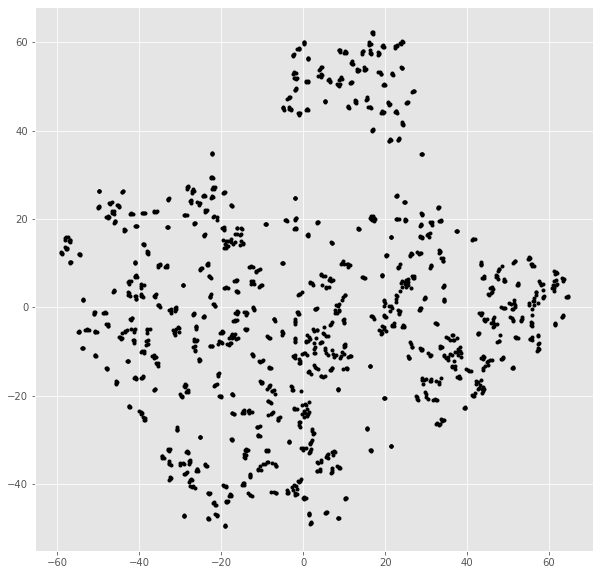

In [304]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne_x5[:, 0]
coord_y = proj_tsne_x5[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

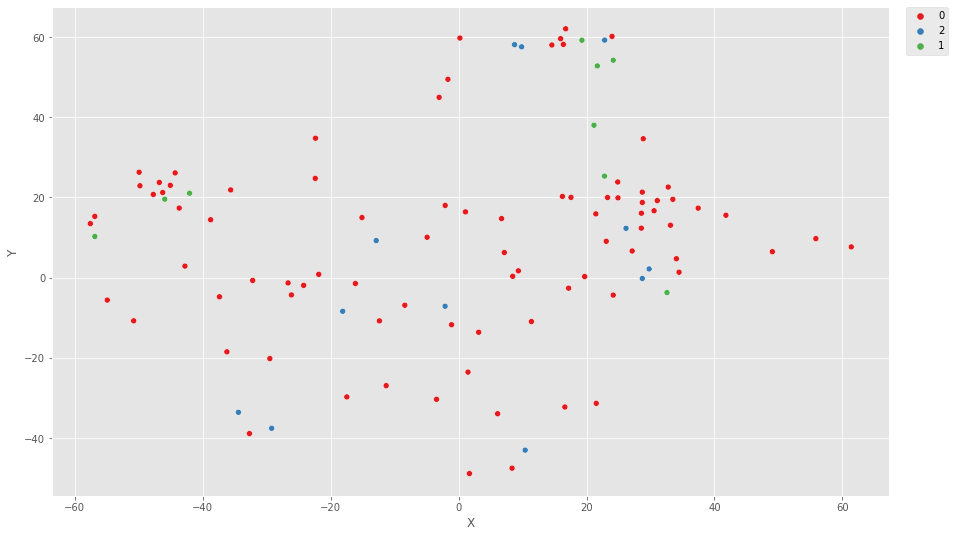

In [305]:
sns.scatterplot(data=tsne_haplo_x5,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Modelos clasificación

In [306]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
from sklearn.metrics import accuracy_score

## CART

### CART  (x1 - Medidas)

In [307]:
pca_haplo_x1.info()

NameError: name 'pca_haplo_x1' is not defined

In [ ]:
nuevo_pca_haplo_x1 = pca_haplo_x1.dropna()

In [ ]:
nuevo_pca_haplo_x1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 9.1+ KB


In [ ]:
X_PCA = nuevo_pca_haplo_x1[['PC1', 'PC2', 'PC3']]
y_PCA = nuevo_pca_haplo_x1['haplogrupos']

In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x1['haplogrupos'],random_state=0)

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

<Figure size 1080x540 with 0 Axes>

[Text(336.44117647058823, 382.21875, 'PC2 <= -0.315\ngini = 0.343\nsamples = 79\nvalue = [63, 7, 9]\nclass = 0'),
 Text(180.52941176470586, 331.25625, 'PC3 <= -1.194\ngini = 0.226\nsamples = 55\nvalue = [48, 1, 6]\nclass = 0'),
 Text(114.88235294117646, 280.29375, 'PC2 <= -0.73\ngini = 0.444\nsamples = 3\nvalue = [1, 0, 2]\nclass = 2'),
 Text(82.05882352941175, 229.33124999999998, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = 2'),
 Text(147.70588235294116, 229.33124999999998, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = 0'),
 Text(246.17647058823528, 280.29375, 'PC2 <= -0.529\ngini = 0.177\nsamples = 52\nvalue = [47, 1, 4]\nclass = 0'),
 Text(213.35294117647058, 229.33124999999998, 'PC2 <= -0.542\ngini = 0.322\nsamples = 26\nvalue = [21, 1, 4]\nclass = 0'),
 Text(131.2941176470588, 178.36875, 'PC1 <= 0.865\ngini = 0.165\nsamples = 22\nvalue = [20, 0, 2]\nclass = 0'),
 Text(65.6470588235294, 127.40625, 'PC1 <= -0.201\ngini = 0.095\nsamples = 20\nvalue = [19, 0, 1]\nclass 

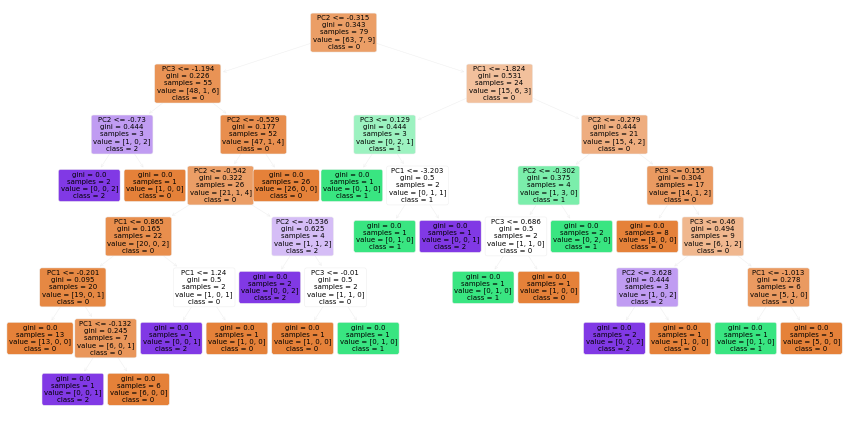

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns)

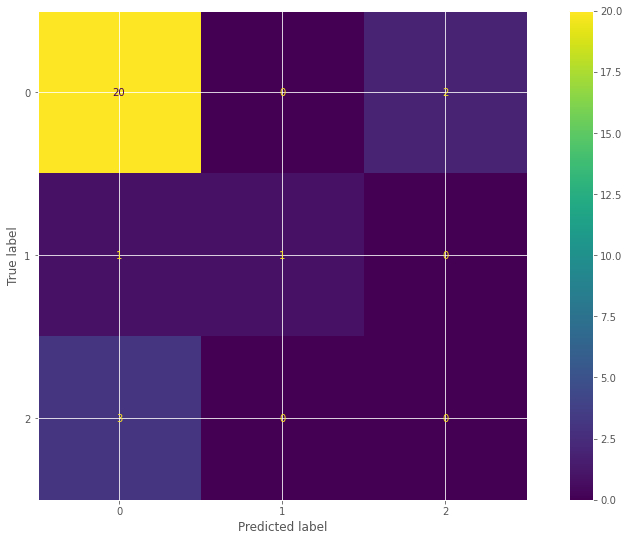

In [ ]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [ ]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7777777777777778

### CART (x2 - Powers)

In [ ]:
pca_haplo_x2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 132.0+ KB


In [ ]:
nuevo_pca_haplo_x2 = pca_haplo_x2.dropna()

In [ ]:
nuevo_pca_haplo_x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   haplogrupos  106 non-null    object 
dtypes: float64(9), object(1)
memory usage: 9.1+ KB


In [ ]:
X_PCA = nuevo_pca_haplo_x2[['PC1', 'PC2', 'PC3']]
y_PCA = nuevo_pca_haplo_x2['haplogrupos']

In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x2['haplogrupos'],random_state=0)

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

<Figure size 1080x540 with 0 Axes>

[Text(414.76339285714283, 385.05, 'PC2 <= -0.747\ngini = 0.343\nsamples = 79\nvalue = [63, 7, 9]\nclass = 0'),
 Text(283.98214285714283, 339.75, 'PC3 <= 2.202\ngini = 0.444\nsamples = 3\nvalue = [1, 0, 2]\nclass = 2'),
 Text(254.08928571428572, 294.45, 'gini = 0.0\nsamples = 2\nvalue = [0, 0, 2]\nclass = 2'),
 Text(313.875, 294.45, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = 0'),
 Text(545.5446428571429, 339.75, 'PC2 <= 3.505\ngini = 0.318\nsamples = 76\nvalue = [62, 7, 7]\nclass = 0'),
 Text(373.6607142857143, 294.45, 'PC1 <= 4.966\ngini = 0.233\nsamples = 62\nvalue = [54, 4, 4]\nclass = 0'),
 Text(269.0357142857143, 249.15, 'PC2 <= -0.555\ngini = 0.193\nsamples = 57\nvalue = [51, 2, 4]\nclass = 0'),
 Text(179.35714285714286, 203.85, 'PC2 <= -0.558\ngini = 0.278\nsamples = 24\nvalue = [20, 0, 4]\nclass = 0'),
 Text(149.46428571428572, 158.55, 'PC3 <= 0.155\ngini = 0.227\nsamples = 23\nvalue = [20, 0, 3]\nclass = 0'),
 Text(89.67857142857143, 113.25, 'PC2 <= -0.591\ngini = 0.4

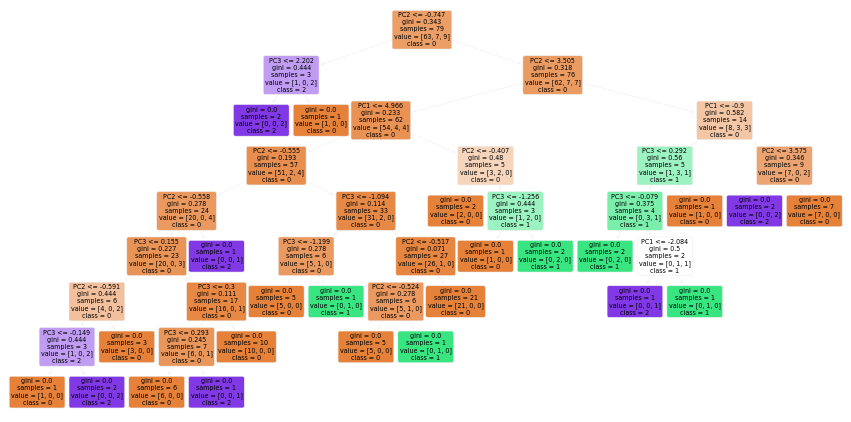

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns)

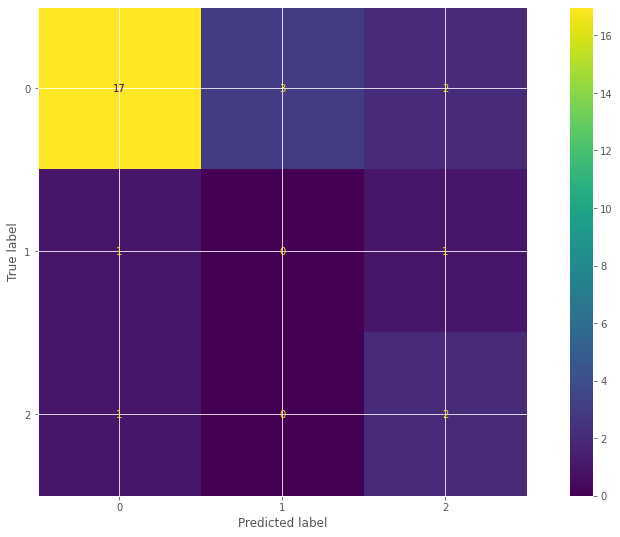

In [ ]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [ ]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7037037037037037

### CART (x3 - Ratios)

In [ ]:
pca_haplo_x3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   PC10         1688 non-null   float64
 10  PC11         1688 non-null   float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 158.4+ KB


In [ ]:
nuevo_pca_haplo_x3 = pca_haplo_x3.dropna()

In [ ]:
nuevo_pca_haplo_x3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 10.8+ KB


In [ ]:
X_PCA = nuevo_pca_haplo_x3[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_PCA = nuevo_pca_haplo_x3['haplogrupos']

In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x3['haplogrupos'],random_state=0)

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

<Figure size 1080x540 with 0 Axes>

[Text(548.0357142857142, 385.05, 'PC5 <= 0.351\ngini = 0.343\nsamples = 79\nvalue = [63, 7, 9]\nclass = 0'),
 Text(338.7857142857143, 339.75, 'PC1 <= -2.669\ngini = 0.491\nsamples = 46\nvalue = [31, 6, 9]\nclass = 0'),
 Text(159.42857142857142, 294.45, 'PC5 <= -0.884\ngini = 0.66\nsamples = 10\nvalue = [3, 4, 3]\nclass = 1'),
 Text(79.71428571428571, 249.15, 'PC2 <= 0.463\ngini = 0.32\nsamples = 5\nvalue = [1, 4, 0]\nclass = 1'),
 Text(39.857142857142854, 203.85, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]\nclass = 0'),
 Text(119.57142857142856, 203.85, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0]\nclass = 1'),
 Text(239.1428571428571, 249.15, 'PC3 <= 2.316\ngini = 0.48\nsamples = 5\nvalue = [2, 0, 3]\nclass = 2'),
 Text(199.28571428571428, 203.85, 'PC2 <= 3.628\ngini = 0.444\nsamples = 3\nvalue = [2, 0, 1]\nclass = 0'),
 Text(159.42857142857142, 158.55, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]\nclass = 0'),
 Text(239.1428571428571, 158.55, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]

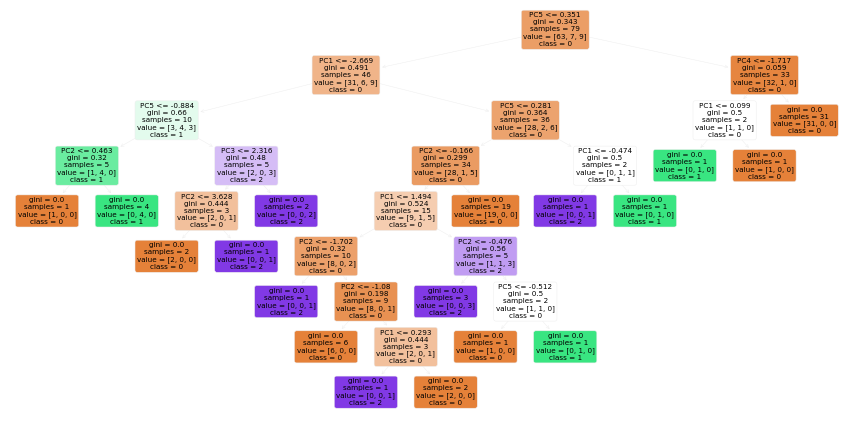

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns)

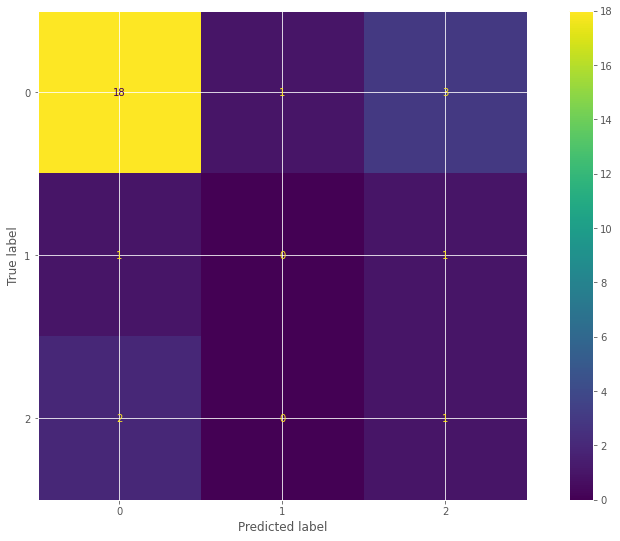

In [ ]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [ ]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7037037037037037

### CART - (x4 - Powers Ratios)

In [ ]:
pca_haplo_x4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   PC10         1688 non-null   float64
 10  PC11         1688 non-null   float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 158.4+ KB


In [ ]:
nuevo_pca_haplo_x4 = pca_haplo_x4.dropna()

In [ ]:
nuevo_pca_haplo_x4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  haplogrupos  106 non-null    object 
dtypes: float64(11), object(1)
memory usage: 10.8+ KB


In [ ]:
X_PCA = nuevo_pca_haplo_x4[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_PCA = nuevo_pca_haplo_x4['haplogrupos']

In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo_x4['haplogrupos'],random_state=0)

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

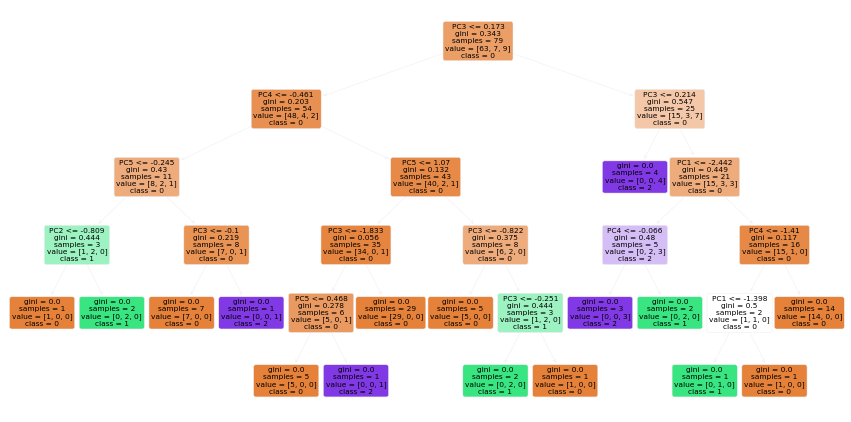

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns); 

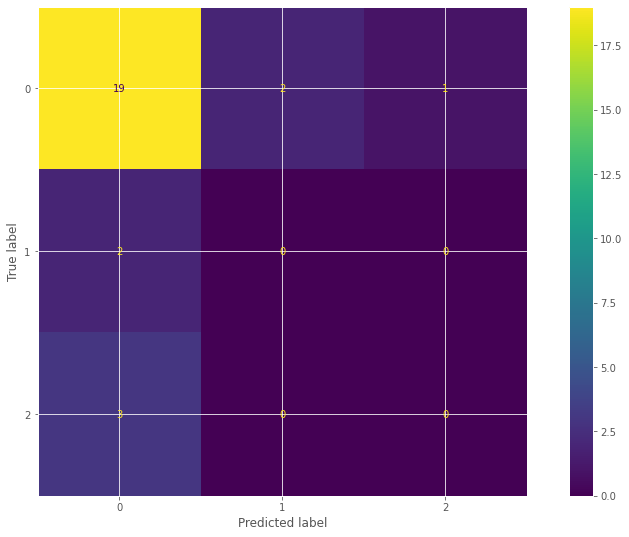

In [ ]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [ ]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.7037037037037037

### CART (x5 - Todas las Futures)

In [ ]:
pca_haplo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          1688 non-null   float64
 1   PC2          1688 non-null   float64
 2   PC3          1688 non-null   float64
 3   PC4          1688 non-null   float64
 4   PC5          1688 non-null   float64
 5   PC6          1688 non-null   float64
 6   PC7          1688 non-null   float64
 7   PC8          1688 non-null   float64
 8   PC9          1688 non-null   float64
 9   PC10         1688 non-null   float64
 10  PC11         1688 non-null   float64
 11  PC12         1688 non-null   float64
 12  PC13         1688 non-null   float64
 13  PC14         1688 non-null   float64
 14  PC15         1688 non-null   float64
 15  PC16         1688 non-null   float64
 16  PC17         1688 non-null   float64
 17  PC18         1688 non-null   float64
 18  CP19         1688 non-null   float64
 19  PC20  

In [ ]:
nuevo_pca_haplo = pca_haplo.dropna()

In [ ]:
nuevo_pca_haplo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 1664
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          106 non-null    float64
 1   PC2          106 non-null    float64
 2   PC3          106 non-null    float64
 3   PC4          106 non-null    float64
 4   PC5          106 non-null    float64
 5   PC6          106 non-null    float64
 6   PC7          106 non-null    float64
 7   PC8          106 non-null    float64
 8   PC9          106 non-null    float64
 9   PC10         106 non-null    float64
 10  PC11         106 non-null    float64
 11  PC12         106 non-null    float64
 12  PC13         106 non-null    float64
 13  PC14         106 non-null    float64
 14  PC15         106 non-null    float64
 15  PC16         106 non-null    float64
 16  PC17         106 non-null    float64
 17  PC18         106 non-null    float64
 18  CP19         106 non-null    float64
 19  PC20   

In [ ]:
X_PCA = nuevo_pca_haplo[['PC1', 'PC2', 'PC3', 'PC4','PC5']]
y_PCA = nuevo_pca_haplo['haplogrupos']

In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = nuevo_pca_haplo['haplogrupos'],random_state=0)

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 10, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

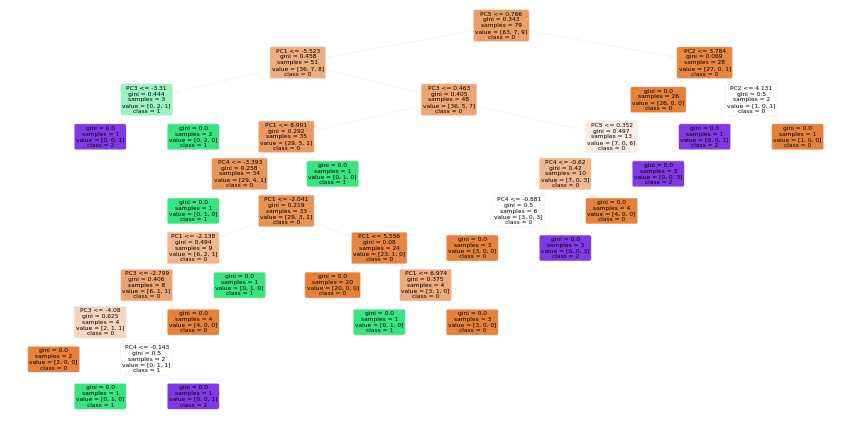

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["0","1", "2"], 
          feature_names=X_train_PCA.columns); 

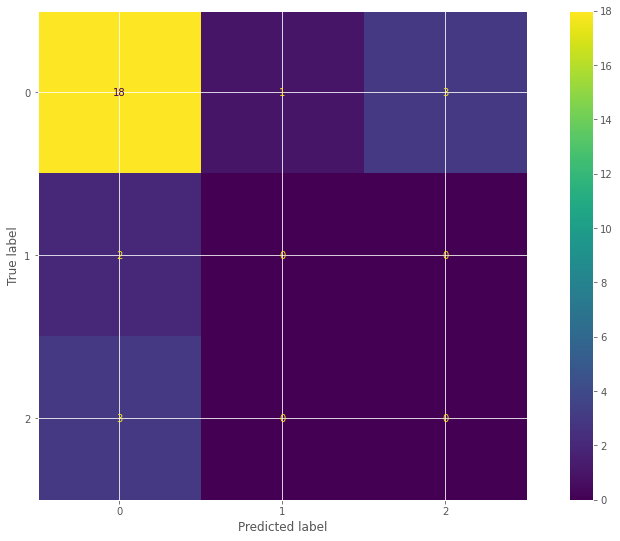

In [ ]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["0","1","2"])

In [ ]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.6666666666666666

## XGBoost

In [ ]:
from xgboost import XGBClassifier


In [ ]:
y_train_PCA = y_train_PCA.astype("int")

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train_PCA)
y_train_PCA = le.transform(y_train_PCA)

LabelEncoder()

In [ ]:
xgboost = XGBClassifier()

In [ ]:
clf_XGB = xgboost.fit(X_train_PCA,y_train_PCA)

In [ ]:
accuracy_score(le.transform(y_test_PCA), xgboost.predict(X_test_PCA))

ValueError: y contains previously unseen labels: '2'